In [67]:
#!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

#!pip install geopy
#!pip install googletrans==3.1.0a0
from googletrans import Translator
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [68]:
df_train = pd.read_csv("train.csv") # 학습용 데이터

In [69]:
df_train.isna().sum() # 결측치 확인

bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate       44731
customer_idx                   0
customer_type              43961
enterprise                     0
historical_existing_cnt    45543
id_strategic_ver           55855
it_strategic_ver           58178
idit_strategic_ver         54734
customer_job               18733
lead_desc_length               0
inquiry_type                 941
product_category           19374
product_subcategory        50064
product_modelname          50070
customer_country.1           982
customer_position              0
response_corporate             0
expected_timeline          30863
ver_cus                        0
ver_pro                        0
ver_win_rate_x             40882
ver_win_ratio_per_bu       43995
business_area              40882
business_subarea           53773
lead_owner                     0
is_converted                   0
dtype: int64

In [9]:
df_train.is_converted.value_counts() # False, True 갯수

is_converted
False    54449
True      4850
Name: count, dtype: int64

### 중복행 제거

In [5]:


# 특수문자 제거, 소문자 변환, 공백 제거
def regenerate(str_c):
    new_str = re.sub(r"[.,~!@#$%^&*\(\)_+=\-~|\\\"\';:\?/\<\>\[\]\{\}]", " ", str_c)
    new_str = ''.join(new_str.split())
    new_str = new_str.strip()
    new_str = new_str.lower()
    
    return new_str

# regenerate function을 범주형 변수에 적용
df_copy = df_train.copy()
df_copy = df_copy.apply(lambda x: [regenerate(i) if not pd.isna(i) else i for i in x])

# 중복 데이터 확인
duplication = df_copy.duplicated().values
duplication = [int(not i) for i in duplication]

# 중복 갯수 산출
idx = 0
for i in range(len(df_train)):
    if len(df_train)-1 == i:
        continue
    
    if duplication[i] == 1:
        idx = i
    else:
        duplication[idx] += 1

# 중복행 갯수 columns 추가
df_train["duplication"] = duplication
df_train = df_train[df_train.duplication != 0]

### 변수 1. bant_submit
- 4가지 문항에서 대답한 비율
- 수치형 변수
- 총 5가지의 값
- 대답의 비율이 높거나 낮다고 해서 True, False의 큰 차이는 없어보임 -> 굳이 따지자면 비율이 0.5인 경우 False에 대한 비율이 늘어남. 그외는 True의 비율이 더 큼
- 그룹화를 시도했으나 0.5인 경우가 어느쪽 그룹에 있느냐의 차이이므로 그룹화하기 쉽지 않아보임

In [11]:
# 응답 비율별 데이터 수
df_train.bant_submit.value_counts().sort_index()

bant_submit
0.00      503
0.25    10728
0.50    16134
0.75    11095
1.00    15656
Name: count, dtype: int64

In [12]:
# False와 True 각각 bant_submit 카테고리들에 해당하는 데이터 비율
# False와 True의 갯수가 다르기 때문에 총합 1로 통일시킨 후 비교

df = pd.DataFrame(df_train.value_counts(["bant_submit", "is_converted"])).reset_index().pivot(index='is_converted', columns='bant_submit', values='count')
df["total"] = df.sum(axis = 1)
pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).T

bant_submit,0.0,0.25,0.5,0.75,1.0
is_converted,,,,,
False,0.008563,0.195084,0.306851,0.201793,0.287709
True,0.017387,0.233170,0.201739,0.240749,0.306955


In [64]:
df = pd.DataFrame(df_train.value_counts(["bant_submit", "is_converted"])).reset_index().pivot(index='is_converted', columns='bant_submit', values='count')
df = df.T
df["total"] = df.sum(axis = 1)
pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1])

bant_submit,0.00,0.25,0.50,0.75,1.00
is_converted,,,,,
False,0.84493,0.902498,0.943907,0.902659,0.912046
True,0.15507,0.097502,0.056093,0.097341,0.087954


In [13]:
# 응답 비율이 0.5 이하, 0.5 초과로 데이터의 카테고리를 나누어 비교
df = df_train.copy()
df.bant_submit = [0 if i <= 0.5 else 1 for i in df.bant_submit]
df = pd.DataFrame(df.value_counts(["bant_submit", "is_converted"])).reset_index().pivot(index='is_converted', columns='bant_submit', values='count')
df["total"] = df.sum(axis = 1)
pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).T

bant_submit,0,1
is_converted,,
False,0.510498,0.489502
True,0.452296,0.547704


In [14]:
# 응답 비율이 0.5 미만, 0.5 이상으로 데이터의 카테고리를 나누어 비교
df = df_train.copy()
df.bant_submit = [0 if i < 0.5 else 1 for i in df.bant_submit]
df = pd.DataFrame(df.value_counts(["bant_submit", "is_converted"])).reset_index().pivot(index='is_converted', columns='bant_submit', values='count')
df["total"] = df.sum(axis = 1)
pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).T

bant_submit,0,1
is_converted,,
False,0.203647,0.796353
True,0.250557,0.749443


### 변수 2. customer_country
- 국적 변수
- 결측치 채우기(동우님 코드) -> 결측치 0개

In [ ]:
# 결측치 수
len(set(df_train.customer_country.dropna()))

In [48]:
def traslate_func(text, attempt = 1, max_attempt = 5):
    try:
        return translator.translate(i, dest = "en").text
    except ReadTimeout:
        if attempt <= max_attempt:
            return translate_func(text, attempt = attempt + 1)
    raise

In [ ]:
# 시간이 오래걸려서 일단은 생략하고 저장해둔 csv 파일을 불러들이면 됩니다. -> 다음 코드

# 규칙에 맞는 국가
def country_func(country_str):
    country_split = country_str.split("//")
    if len(country_split) != 1 and country_split[1].strip() != "":
        country_str = country_split[1].strip()
    elif len(country_str.split("/")) != 1 and country_str.split("/")[-1] != "":
        country_str = country_str.split("/")[-1]
    return country_str

# 규칙에 맞지 않는 국가 - 약 40분
def geo_country(country_str, attempt = 1, max_attempt = 5):
    time.sleep(1)
    global n
    global start_t
    try:
        n += 1
        geo = geolocoder.geocode(country_str)
        if pd.isna(geo):
            country_str = geo
        else:
            country_str = geo[0].split(",")[-1].strip()
        if n % 100 ==0:
            print("------------------ Step {} : {} -------------------".format(n, time.time() - start_t))
            start_t = time.time()
        return country_str
    except GeocoderTimedOut:
        if attempt <= max_attempt:
            return geo_country(country_str, attempt=attempt+1)
        raise
df_train.customer_country = [country_func(i) if not pd.isna(i) else i for i in df_train.customer_country]

n = 0
start_t = time.time()
geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
country = list(set(df_train.customer_country))
conversion = [geo_country(i) if not pd.isna(i) else i for i in country]

# 번역
translator = Translator()
start = time.time()
conversion_trans = [i.split("/")[-1] if not pd.isna(i) else i for i in conversion]
conversion_trans = [translator.translate(i, dest="en").text if not pd.isna(i) else i for i in conversion_trans]

# 카테고리명 변경
conversion_df = pd.DataFrame([country, conversion_trans]).T
conversion_df.columns = ["country", "conversion"]
conversion_dict = conversion_df.set_index("country").T.to_dict()
conversion_re = [conversion_dict[i]["conversion"] if not pd.isna(i) else i for i in df_train.customer_country]

# 국가를 찾을 수 없는 카테고리는 원래의 카테고리명으로
conversion_na = [df_train.customer_country.iloc[i] if pd.isna(conversion_re[i]) else conversion_re[i] for i in range(len(conversion_re))]

# 국가를 찾을 수 없는 카테고리는 etc로 변경
conversion_etc = ["etc" if pd.isna(conversion_re[i]) else conversion_re[i] for i in range(len(conversion_re))]

In [42]:
df_train.customer_country = conversion.country.tolist()
df_train.customer_country.isna().sum()

0

In [30]:
df = pd.DataFrame(df_train.value_counts(["customer_country", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_country', values='count')
df.T.sort_values(True, ascending = False)

is_converted,False,True
customer_country,,
India,15338.0,1171.0
United States,3982.0,709.0
Brazil,7551.0,558.0
Philippines,2250.0,223.0
etc,2057.0,217.0
...,...,...
Viti,4.0,NaN
Yemen,14.0,NaN
Zambia,6.0,NaN


In [23]:
len(set(df.customer_country))

149

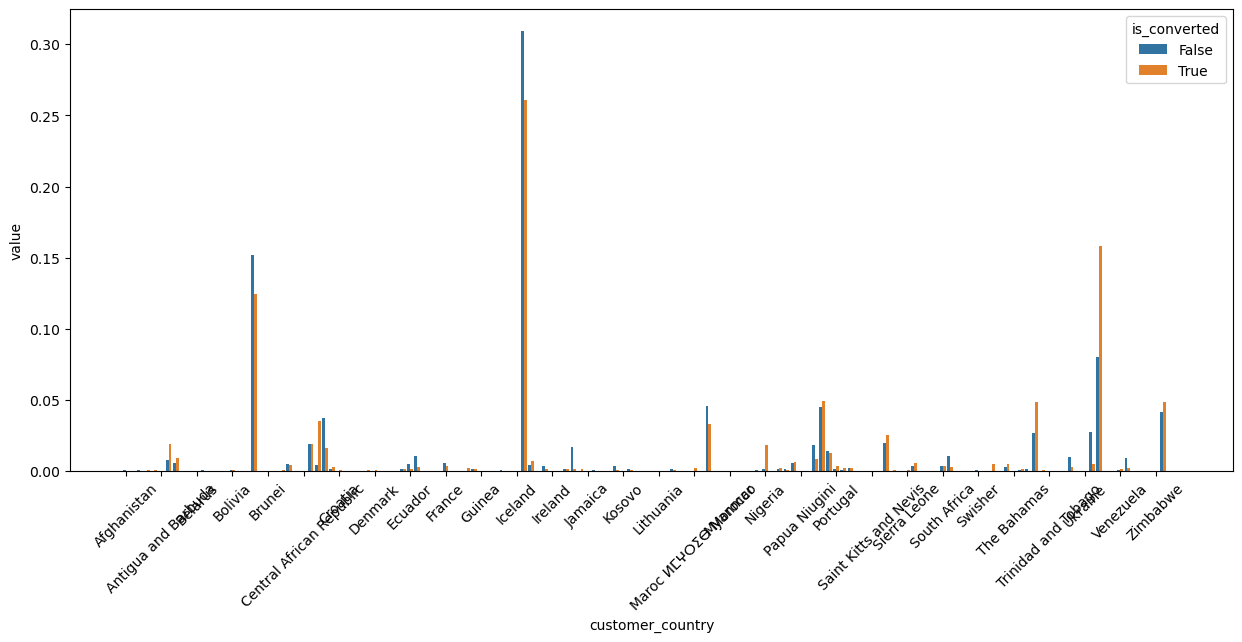

In [18]:
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['customer_country'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
sns.barplot(x= 'customer_country', y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(df)/10)

plt.show()

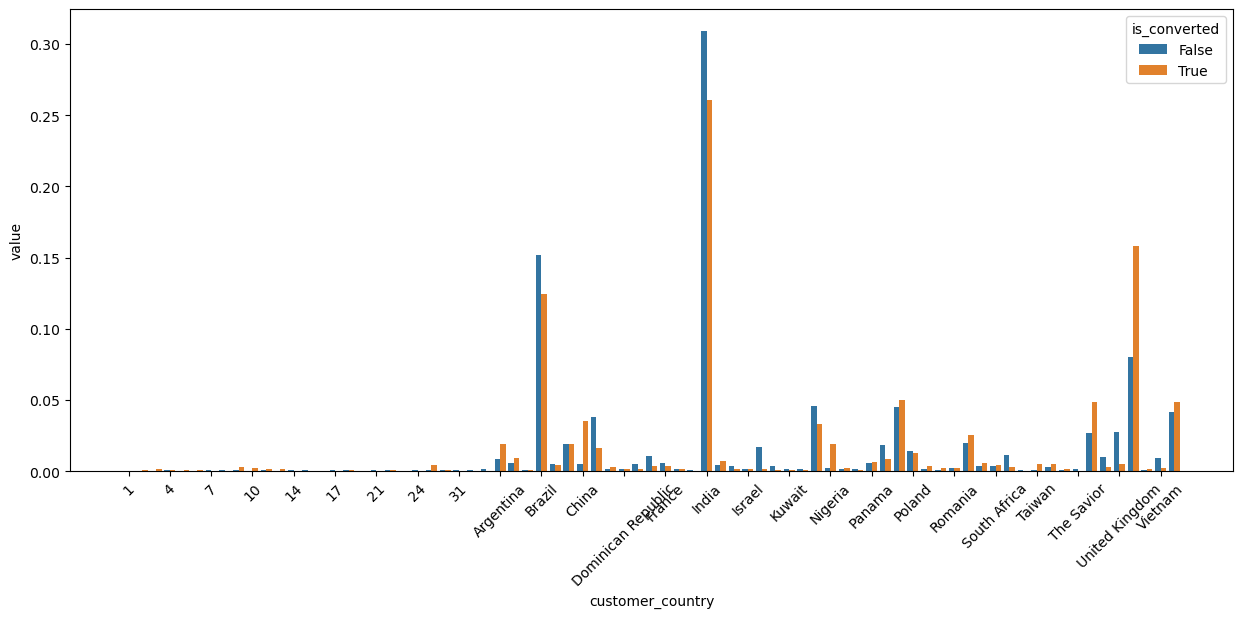

In [91]:
# 1번 시도한 나라들은 1, 2번 시도한 나라들은 2로 그룹화하여 비교
df = df_train.copy()
count_df = df.customer_country.value_counts()
idx = df_train.customer_country.value_counts()[df_train.customer_country.value_counts()>40].index
df.customer_country = [count_df[i] if i not in idx else i for i in df.customer_country]

df = pd.DataFrame(df.value_counts(["customer_country", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_country', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['customer_country'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "customer_country", y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(df.customer_country)/5)

plt.show()

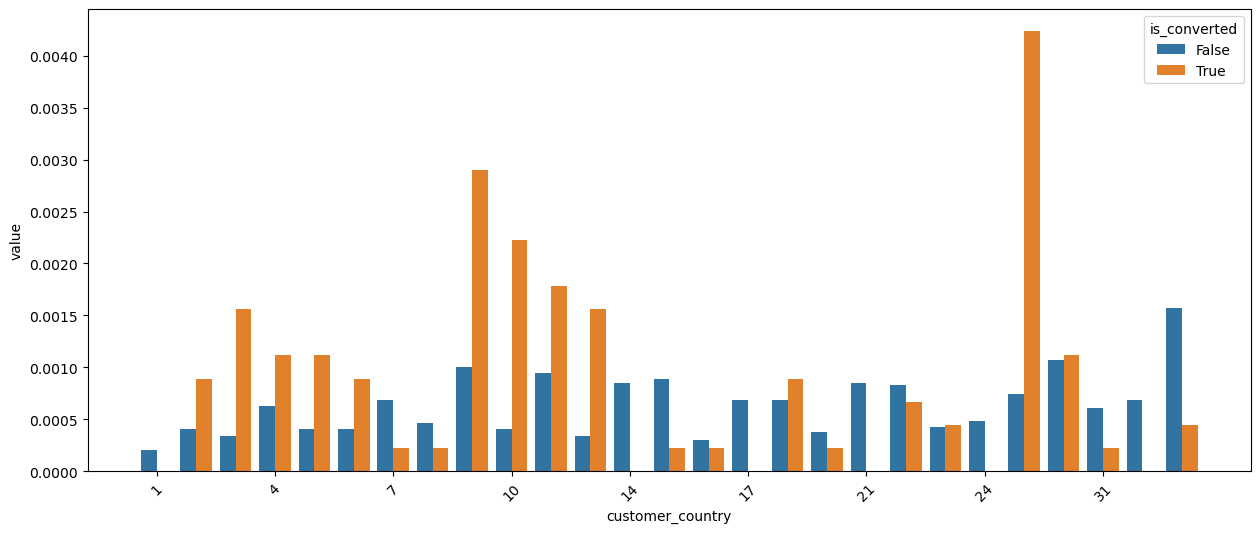

In [89]:
df = df_train.copy()
count_df = df.customer_country.value_counts()
idx = df_train.customer_country.value_counts()[df_train.customer_country.value_counts()>40].index
df.customer_country = [count_df[i] if i not in idx else i for i in df.customer_country]

df = pd.DataFrame(df.value_counts(["customer_country", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_country', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0).iloc[0:27]
df = pd.melt(df.reset_index(), id_vars=['customer_country'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "customer_country", y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(df.customer_country)/5)

plt.show()

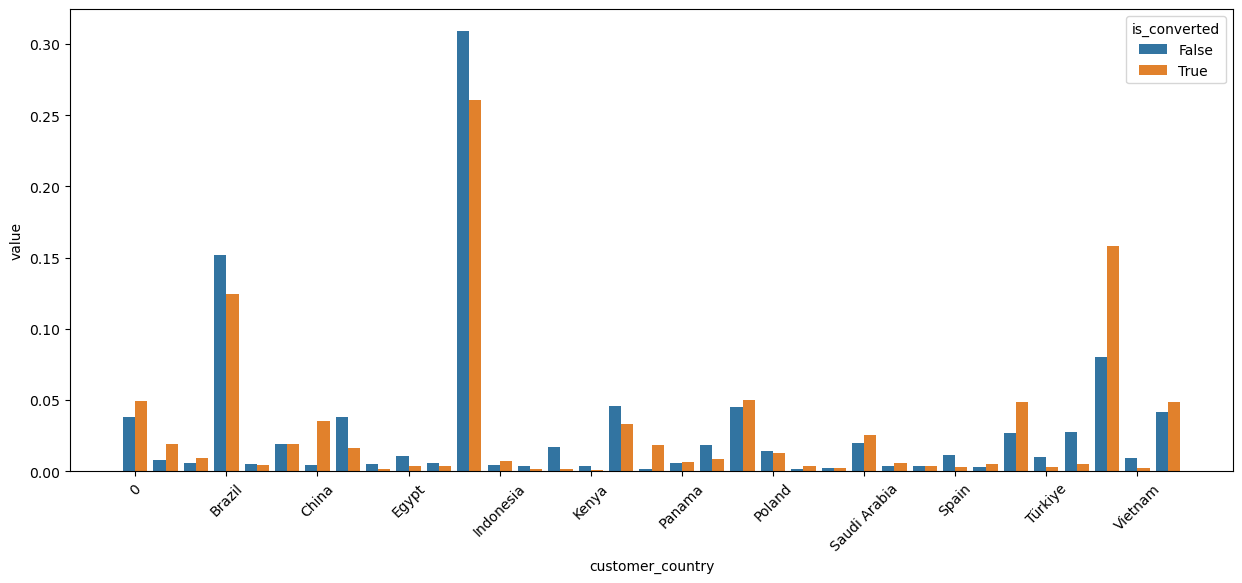

In [85]:
# 100 이하는 하나의 카테고리로 통합
df = df_train.copy()
idx = df_train.customer_country.value_counts()[df_train.customer_country.value_counts()>100].index
df.customer_country = [0 if i not in idx else i for i in df.customer_country]

df = pd.DataFrame(df.value_counts(["customer_country", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_country', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['customer_country'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "customer_country", y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(df.customer_country)/5)

plt.show()

### 변수 3. business_unit
- MQL 요청 상품에 대응되는 사업부
- 5가지 카테고리로 구성된 범주형 변수, 결측치 없음
- AS, Solution, CM, IT 부서는 True인 경우보다 False인 경우 비율이 더 높았다.
- ID 부서의 경우 False인 경우보다 True인 경우 비율이 더 높았다.
- CM, Solution의 경우는 거의 False이다.


In [84]:
df_train.business_unit.isna().sum()

0

In [85]:
set(df_train.business_unit)

{'AS', 'CM', 'ID', 'IT', 'Solution'}

In [86]:
df = pd.DataFrame(df_train.value_counts(["business_unit", "is_converted"])).reset_index().pivot(index='is_converted', columns='business_unit', values='count')
df["total"] = df.sum(axis = 1)
pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).T.fillna(0)

business_unit,AS,CM,ID,IT,Solution
is_converted,,,,,
False,0.418577,0.00002,0.43242,0.143260,0.005722
True,0.300267,0.00000,0.55885,0.140214,0.000669


In [87]:
pd.DataFrame(df_train.value_counts(["business_unit", "is_converted"])).reset_index().pivot(index='is_converted', columns='business_unit', values='count')

business_unit,AS,CM,ID,IT,Solution
is_converted,,,,,
False,20774.0,1.0,21461.0,7110.0,284.0
True,1347.0,NaN,2507.0,629.0,3.0


### 변수 4. com_reg_ver_win_rate
- Vertical Level 1(?), 사업부, 지역을 기준으로 Oppty(Sales Opportunity) 즉, 영업기회 비율 -> https://berrynewton.tistory.com/entry/%EC%A7%81%EB%AC%B4%ED%83%90%EC%83%89-Lead-Generation-%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4-1-DGR-SDR-BDR-%EB%93%B1
- 값이 낮아질수록 False의 비율이 더 커지고, 값이 커질수록 True의 비율이 더 커지는 것을 볼 수 있다.
- 이상치 제거를 해야할까?

In [88]:
df_train.com_reg_ver_win_rate.isna().sum()

40609

In [89]:
len(set(df_train.com_reg_ver_win_rate.dropna()))

80

<Axes: >

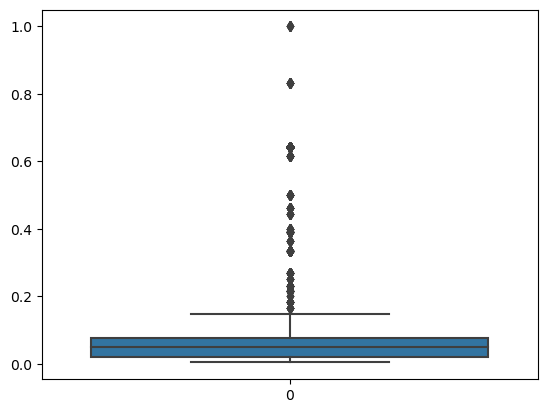

In [90]:
sns.boxplot(df_train.com_reg_ver_win_rate)

In [95]:
df_train.com_reg_ver_win_rate.dropna().sort_values()

55429    0.003788
55731    0.003788
55732    0.003788
55733    0.003788
55734    0.003788
           ...   
28822    1.000000
28816    1.000000
58876    1.000000
58879    1.000000
31629    1.000000
Name: com_reg_ver_win_rate, Length: 13507, dtype: float64

In [91]:
df = pd.DataFrame(df_train.value_counts(["com_reg_ver_win_rate", "is_converted"])).reset_index().pivot(index='is_converted', columns='com_reg_ver_win_rate', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['com_reg_ver_win_rate'], value_vars=[False, True])


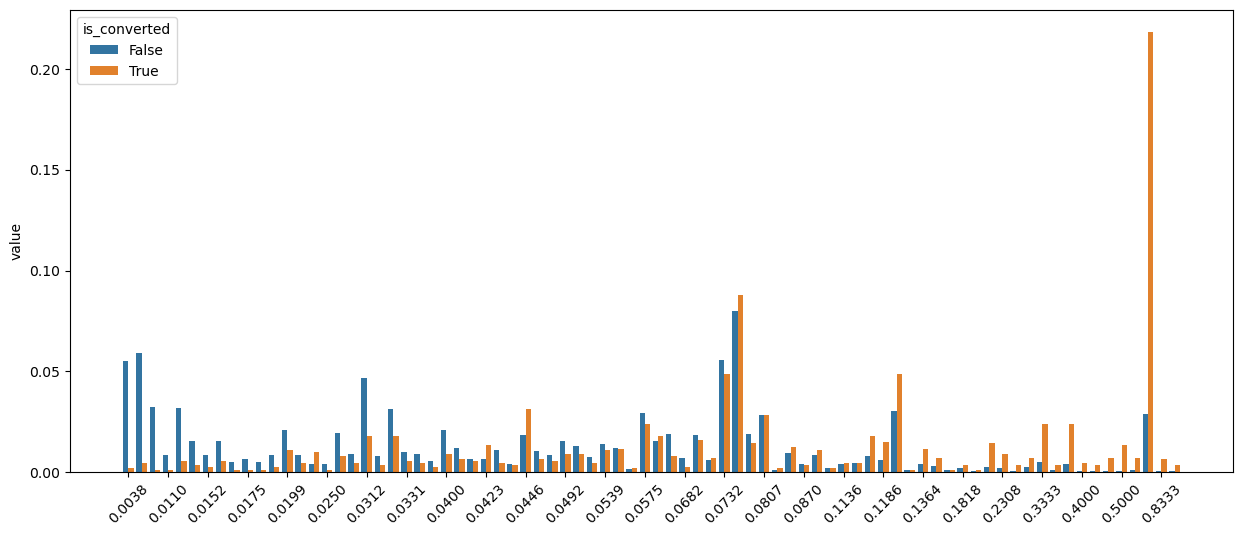

In [93]:
fig,ax = plt.subplots(figsize=(15,6))
xlabels = ["%0.4f" % i for i in df.com_reg_ver_win_rate]
plt.xticks(rotation=45)
ax = sns.barplot(x= xlabels, y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(xlabels)/5)

plt.show()

### 변수 5. customer_idx
- 고객의 회사명
- 범주형인데 회사가 총 35112로 너무 많음
- 회사명이 25096인 회사는 전부 영업전환

In [104]:
len(set(df_train.customer_idx))

35112

In [303]:
# 성공횟수/시도횟수가 전체 비율을 넘는 경우를 뽑아봄
t = sum(df_train.is_converted)/len(df_train)
df = df_train.copy()
df = pd.DataFrame(df.value_counts(["customer_idx", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_idx', values='count').T
df["total"] = df.sum(axis = 1)
df_per = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = ["False_Per","True_per"]).fillna(0).T
df = pd.concat([df, df_per], axis = 1)
df[(df["True_per"]>t)&(df.total>5)].sort_values(True, ascending = False).head()

,False,True,total,False_Per,True_per
customer_idx,,,,,
25096,NaN,2404.0,2404.0,0.000000,1.000000
26337,1.0,13.0,14.0,0.071429,0.928571
9857,NaN,11.0,11.0,0.000000,1.000000
27735,3.0,10.0,13.0,0.230769,0.769231
45319,1.0,9.0,10.0,0.100000,0.900000


In [56]:
t = sum(df_train.is_converted)/len(df_train)
df = df_train.copy()
df = pd.DataFrame(df.value_counts(["customer_idx", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_idx', values='count').T
df["total"] = df.sum(axis = 1)
df_per = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = ["False_Per","True_per"]).fillna(0).T
df = pd.concat([df, df_per], axis = 1)
df = df.fillna(0)
df.sort_values("total", ascending = False).tail(20)

,False,True,total,False_Per,True_per
customer_idx,,,,,
17466,1.0,0.0,1.0,1.0,0.0
17464,1.0,0.0,1.0,1.0,0.0
17463,1.0,0.0,1.0,1.0,0.0
17462,1.0,0.0,1.0,1.0,0.0
17460,1.0,0.0,1.0,1.0,0.0
17457,1.0,0.0,1.0,1.0,0.0
17456,1.0,0.0,1.0,1.0,0.0
17454,1.0,0.0,1.0,1.0,0.0
17452,1.0,0.0,1.0,1.0,0.0


In [59]:
df[df.total == 1].True_per.mean()

0.046225843377550334

In [60]:
df[df.total == 2].True_per.mean()

0.03801377999524828

In [61]:
df[df.total == 3].True_per.mean()

0.04973544973544974

In [ ]:
df.sort_values(True, ascending = False).head()

In [ ]:
t = sum(df_train.is_converted)/len(df_train)
df = df_train.copy()
df = pd.DataFrame(df.value_counts(["customer_idx", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_idx', values='count').T
df["total"] = df.sum(axis = 1)
df_per = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = ["False_Per","True_per"]).fillna(0).T
df = pd.concat([df, df_per], axis = 1)
df[(df["True_per"]>t)&(df.total>5)].sort_values(True, ascending = False).head()

In [300]:
len(df[(df["True_per"]>t)&(df.total>5)])

31

In [349]:
df = df_train.copy()
df = pd.DataFrame(df.value_counts(["customer_idx", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_idx', values='count').T
df["total"] = df.sum(axis = 1)
df = df[df.total>5] # 5번 이상인 회사 추출
df_per = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = ["False_per","True_per"]).fillna(0).T
df = pd.concat([df, df_per], axis = 1)
df[["total","True_per"]].corr(method='pearson')


,total,True_per
total,1.000000,0.081986
True_per,0.081986,1.000000


In [352]:
df = df_train.copy()
df = pd.DataFrame(df.value_counts(["customer_idx", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_idx', values='count').T
df["total"] = df.sum(axis = 1)
df_per = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = ["False_Per","True_per"]).fillna(0).T
df = pd.concat([df, df_per], axis = 1)
df.sort_values("total", ascending = False).head()

,False,True,total,False_Per,True_per
customer_idx,,,,,
47466,6711.0,61.0,6772.0,0.990992,0.009008
25096,NaN,2404.0,2404.0,0.000000,1.000000
37680,318.0,4.0,322.0,0.987578,0.012422
21321,150.0,1.0,151.0,0.993377,0.006623
18030,120.0,1.0,121.0,0.991736,0.008264


In [346]:
df = df_train.copy()
df = pd.DataFrame(df.value_counts(["customer_idx", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_idx', values='count').T
df["total"] = df.sum(axis = 1)
df_per = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = ["False_per","True_per"]).fillna(0).T
df = pd.concat([df, df_per], axis = 1)

df = pd.DataFrame(df.False_per < df.True_per, columns = ["is_converted"]).reset_index()
costomer_dict = df.set_index("customer_idx").T.to_dict()

result = [costomer_dict[i]["is_converted"] if not pd.isna(i) else i for i in df_train.customer_idx]

In [347]:
sum(result)/len(df_train)

0.07792519772340897

In [325]:
df = df.sort_values("total", ascending = False)

In [107]:
# 20 이하는 하나의 카테고리로 통합
df = df_train.copy()
idx = df_train.customer_idx.value_counts()[df_train.customer_idx.value_counts()>20].index
df.customer_idx = [0 if i not in idx else i for i in df.customer_idx]
df = pd.DataFrame(df.value_counts(["customer_idx", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_idx', values='count')
df.T

is_converted,False,True
customer_idx,,
0,41214.0,2007.0
742,27.0,NaN
4936,26.0,NaN
7195,47.0,NaN
7810,21.0,NaN
9624,21.0,NaN
18030,120.0,1.0
19804,63.0,1.0
21321,150.0,1.0


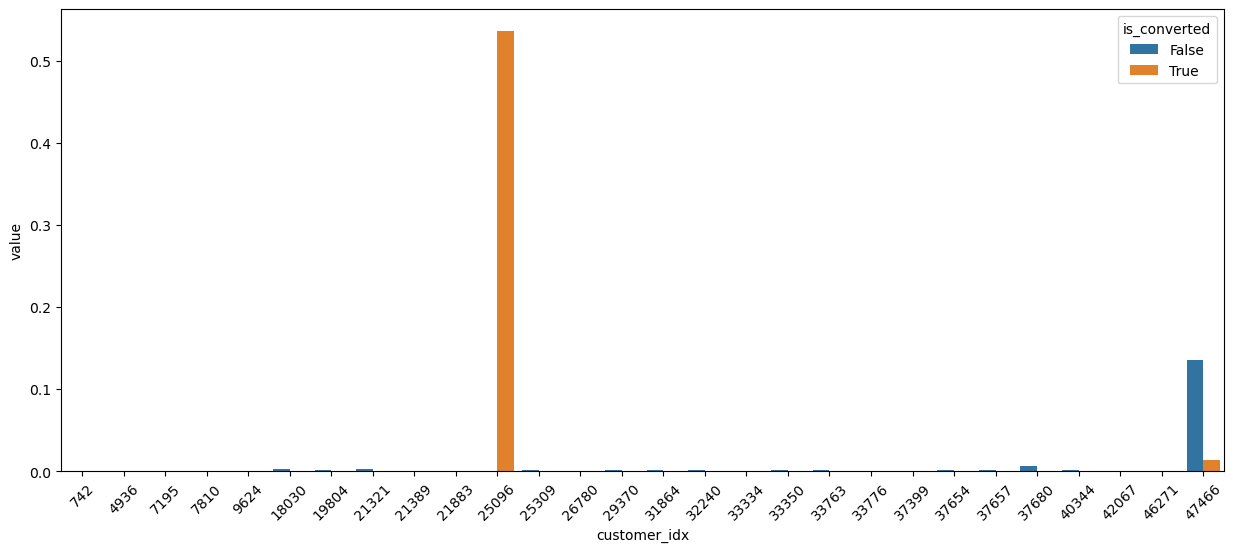

In [260]:
fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "customer_idx", y="value", hue = "is_converted", data = df[df.customer_idx!=0])

plt.show()

In [108]:
df = df_train.copy()
count_df = df.customer_idx.value_counts()
idx = df_train.customer_idx.value_counts()[df_train.customer_idx.value_counts()>20].index
df.customer_idx = [count_df[i] if i not in idx else i for i in df.customer_idx]
df = pd.DataFrame(df.value_counts(["customer_idx", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_idx', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['customer_idx'], value_vars=[False, True])

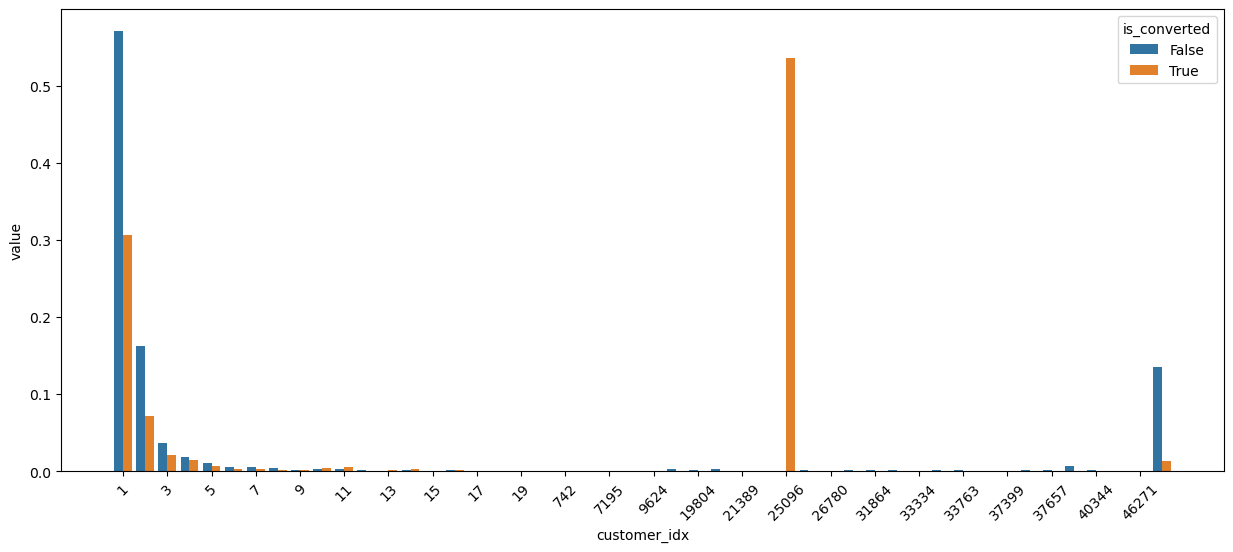

In [109]:
fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "customer_idx", y="value", hue = "is_converted", data = df[df.customer_idx!=0])
ax.locator_params(axis='x', nbins=len(xlabels)/5)

plt.show()

### 변수 6. customer_type
- 고객 유형
- 결측치가 상당히 많음 : 약 76%가 결측치
- 특수문자 및 공백 삭제, 유사한 카테고리 결합한 결과 총 23개의 카테고리
- 결측치도 너무 많고 특별히 보이는 특징이 없음

In [101]:
df_train.customer_type.isna().sum()/len(df_train)

0.7560610540320792

In [102]:
df_train.customer_type = [re.sub(r"[.,~!@#$%^&*\(\)_+=\-~|\\\"\';:\?/\<\>\[\]\{\}]", " ", customer) if not pd.isna(customer) else customer for customer in df_train.customer_type]
df_train.customer_type = [' '.join(customer.split()) if not pd.isna(customer) else customer for customer in df_train.customer_type]
set(df_train.customer_type)

{'Administrator',
 'Architect Consultant',
 'Channel Partner',
 'Commercial end user',
 'Consultant',
 'Corporate',
 'Dealer Distributor',
 'Developer',
 'Distributor',
 'End Customer',
 'End user',
 'Engineer',
 'Etc',
 'HVAC Engineer',
 'Home Owner',
 'Homeowner',
 'Installer',
 'Installer Contractor',
 'Interior Designer',
 'Manager Director',
 'Other',
 'Others',
 'Reseller',
 'Service Partner',
 'Software Solution Provider',
 'Solution Eco Partner',
 'Specifier Influencer',
 'System Integrator',
 'Technical Assistant',
 'Technician',
 nan}

In [103]:
# 'Architect Consultant' 와 'Consultant' 결합
# 'Dealer Distributor' 와 'Distributor' 결합
# 'End Customer' 와 'End user' 결합
# 'HVAC Engineer' 와 'Engineer' 결합
# 'Home Owner' 와 'Homeowner' 결합
# 'Installer Contractor' 와 'Installer' 결합
# 'Other'와 'Others' 결합
# 'Technical Assistant'와 'Technician' 결합

df_train.customer_type = df_train.customer_type.replace(['Architect Consultant','Dealer Distributor', 'End Customer', 'HVAC Engineer'
                                                      , 'Homeowner', 'Installer Contractor', 'Other', 'Technical Assistant'],
                                                     ['Consultant','Distributor', 'End user', 'Engineer', 'Home Owner', 'Installer', 'Others', 'Technician'])

In [104]:
len(set(df_train.customer_type))

23

In [105]:
df_train.customer_type.value_counts()

customer_type
End user                      9089
Specifier Influencer          2254
Channel Partner               1228
Service Partner                298
Solution Eco Partner           115
Installer                       47
Engineer                        35
Corporate                       23
Consultant                      20
Technician                      17
Others                          14
Developer                       12
Home Owner                      11
Manager Director                 7
Software Solution Provider       7
Distributor                      6
Etc                              6
Interior Designer                5
Reseller                         4
System Integrator                1
Commercial end user              1
Administrator                    1
Name: count, dtype: int64

In [106]:
df = pd.DataFrame(df_train.value_counts(["customer_type", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_type', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['customer_type'], value_vars=[False, True])

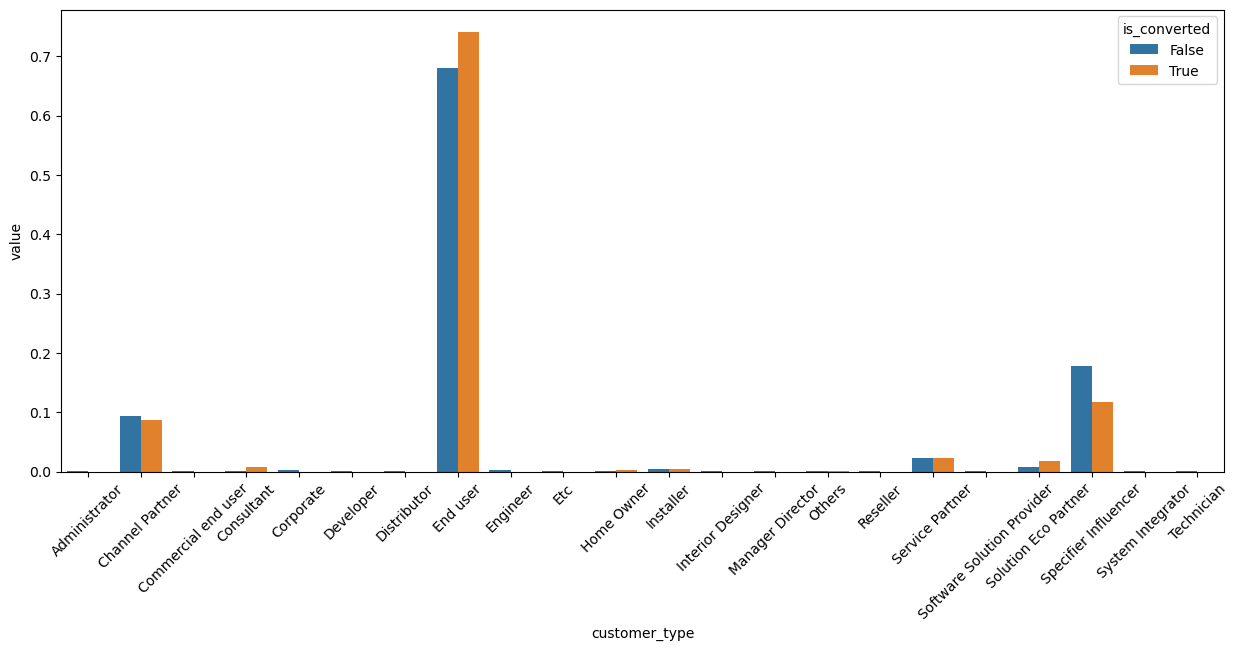

In [108]:
fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "customer_type", y="value", hue = "is_converted", data = df)

plt.show()

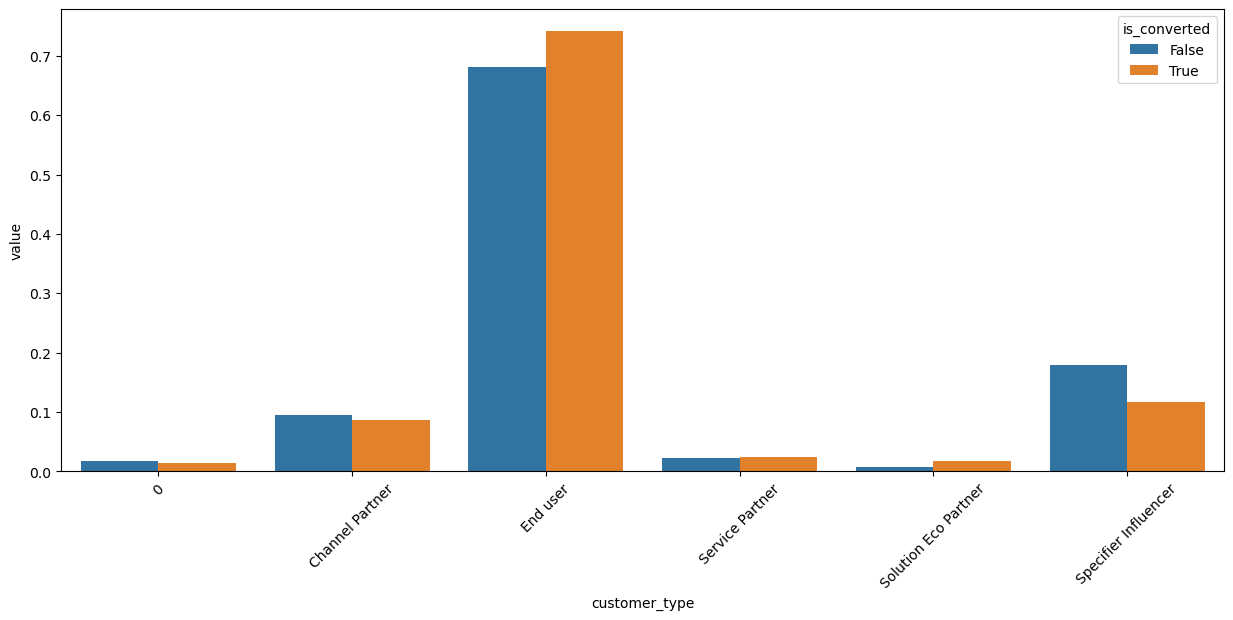

In [127]:
# 100 이하는 하나의 카테고리로 통합
df = df_train.copy()
idx = df_train.customer_type.value_counts()[df_train.customer_type.value_counts()>100].index
df.customer_type = [0 if i not in idx and not pd.isna(i) else i for i in df.customer_type]

df = pd.DataFrame(df.value_counts(["customer_type", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_type', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).dropna()
df = pd.melt(df.reset_index(), id_vars=['customer_type'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "customer_type", y="value", hue = "is_converted", data = df)

plt.show()

### 변수 7. enterprise
- 기업의 규모
- 결측치는 없고, 2가지 카테고리로 이루어진 범주형 변수
- 대기업인 경우는 False, 중소인 경우는 True에서의 비율이 높음
- 회사명이 같은데 몇 개는 중소, 몇 개는 대기업인 경우가 있음 -> 설명이 필요

In [118]:
df_train.enterprise.isna().sum()

0

In [119]:
set(df_train.enterprise)

{'Enterprise', 'SMB'}

In [120]:
df_train.enterprise.value_counts()

enterprise
Enterprise    34833
SMB           19283
Name: count, dtype: int64

In [121]:
df = pd.DataFrame(df_train.value_counts(["enterprise", "is_converted"])).reset_index().pivot(index='is_converted', columns='enterprise', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df.T

enterprise,Enterprise,SMB
is_converted,,
False,0.661354,0.338646
True,0.448061,0.551939


In [6]:
# 회사명이 같은데 몇개는 중소이고, 몇개는 대기업이다...?
df = pd.DataFrame(df_train.value_counts(["customer_idx", "enterprise"])).reset_index().pivot(index='enterprise', columns='customer_idx', values='count').T
len(set(df.Enterprise.dropna().index) & set(df.SMB.dropna().index))

572

In [4]:
pd.DataFrame(df_train.value_counts(["customer_idx", "enterprise"])).reset_index()

,customer_idx,enterprise,count
0,47466,Enterprise,7678
1,25096,SMB,1238
2,25096,Enterprise,1183
3,37680,Enterprise,344
4,18030,Enterprise,244
...,...,...,...
35679,22015,SMB,1
35680,22014,SMB,1
35681,22013,SMB,1
35682,22012,SMB,1


### 변수 8. historical_existing_cnt
- 이전 영업 전환 횟수
- 결측치가 상당히 많음 : 약 78%
- 다른 변수와의 연관을 찾아 결측치를 채우는 것이 아니면 의미가 없다고 생각 -> 이전 영업 전환 횟수가 많다고 다음 영업과 연관이 있어보이진 않음

In [123]:
df_train.historical_existing_cnt.isna().sum()/len(df_train)

0.7763692808041984

In [124]:
len(set(df_train.historical_existing_cnt.dropna()))

136

In [125]:
max(df_train.historical_existing_cnt.dropna())

1394.0

In [126]:
df = pd.DataFrame(df_train.value_counts(["historical_existing_cnt", "is_converted"])).reset_index().pivot(index='is_converted', columns='historical_existing_cnt', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['historical_existing_cnt'], value_vars=[False, True])

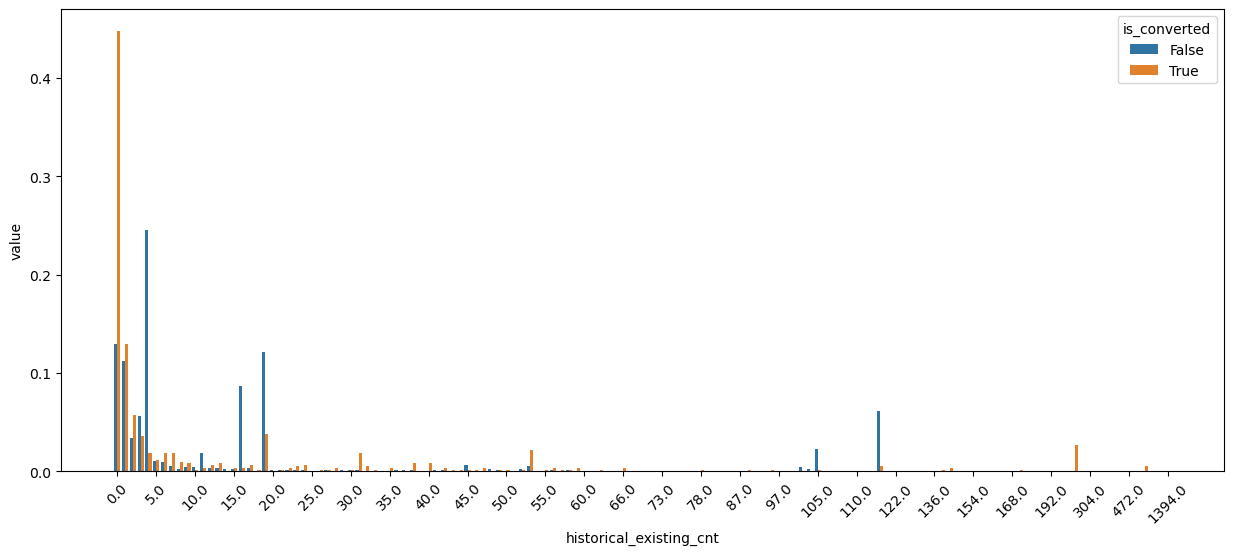

In [127]:
fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "historical_existing_cnt", y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(xlabels)/5)

plt.show()

In [128]:
df = pd.DataFrame(df_train.value_counts(["historical_existing_cnt", "is_converted"])).reset_index().pivot(index='is_converted', columns='historical_existing_cnt', values='count').T
df[df.index > 20].sum(axis=0)/df.sum(axis = 0)

is_converted
False    0.145057
True     0.173770
dtype: float64

In [129]:
df[df.index > 20].sum(axis=0)

is_converted
False    1667.0
True      106.0
dtype: float64

<Axes: >

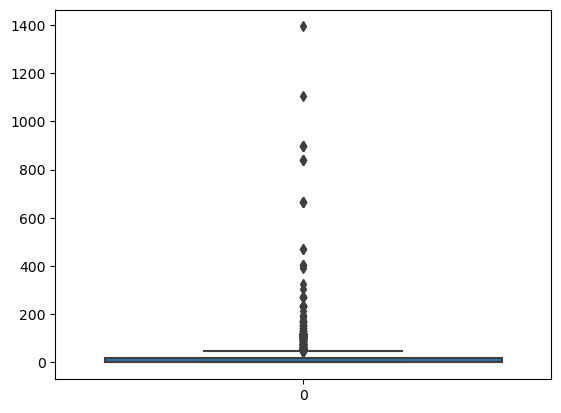

In [130]:
sns.boxplot(df_train.historical_existing_cnt)

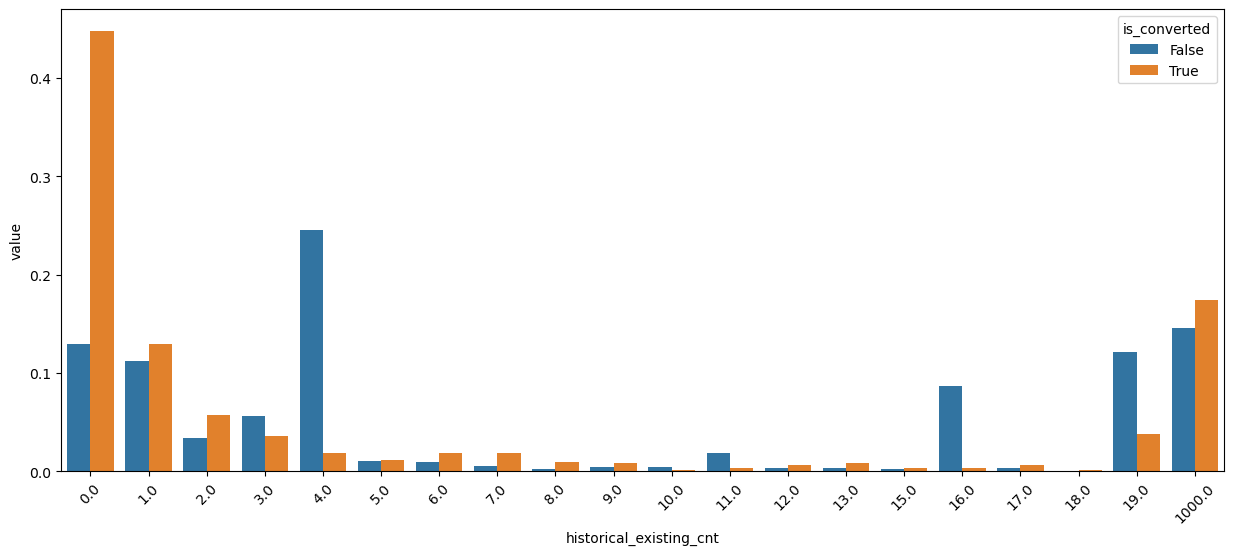

In [145]:
# 이전 영업횟수가 20 이상은 하나의 카테고리로 통합
df = df_train.copy()
idx = list(range(0,20))
df.historical_existing_cnt = [1000 if i not in idx and not pd.isna(i) else i for i in df.historical_existing_cnt]

df = pd.DataFrame(df.value_counts(["historical_existing_cnt", "is_converted"])).reset_index().pivot(index='is_converted', columns='historical_existing_cnt', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).dropna()
df = pd.melt(df.reset_index(), id_vars=['historical_existing_cnt'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "historical_existing_cnt", y="value", hue = "is_converted", data = df)

plt.show()

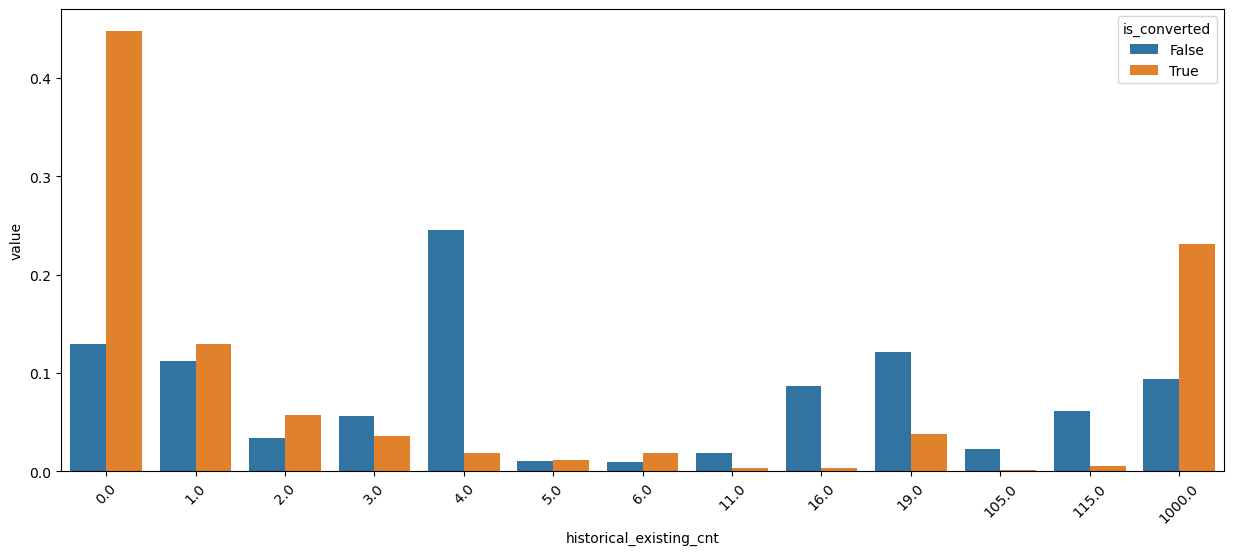

In [142]:
# total 갯수가 100 이하는 하나의 카테고리로 통합
df = df_train.copy()
idx = df_train.historical_existing_cnt.value_counts()[df_train.historical_existing_cnt.value_counts()>100].index
df.historical_existing_cnt = [1000 if i not in idx and not pd.isna(i) else i for i in df.historical_existing_cnt]

df = pd.DataFrame(df.value_counts(["historical_existing_cnt", "is_converted"])).reset_index().pivot(index='is_converted', columns='historical_existing_cnt', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).dropna()
df = pd.melt(df.reset_index(), id_vars=['historical_existing_cnt'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "historical_existing_cnt", y="value", hue = "is_converted", data = df)

plt.show()

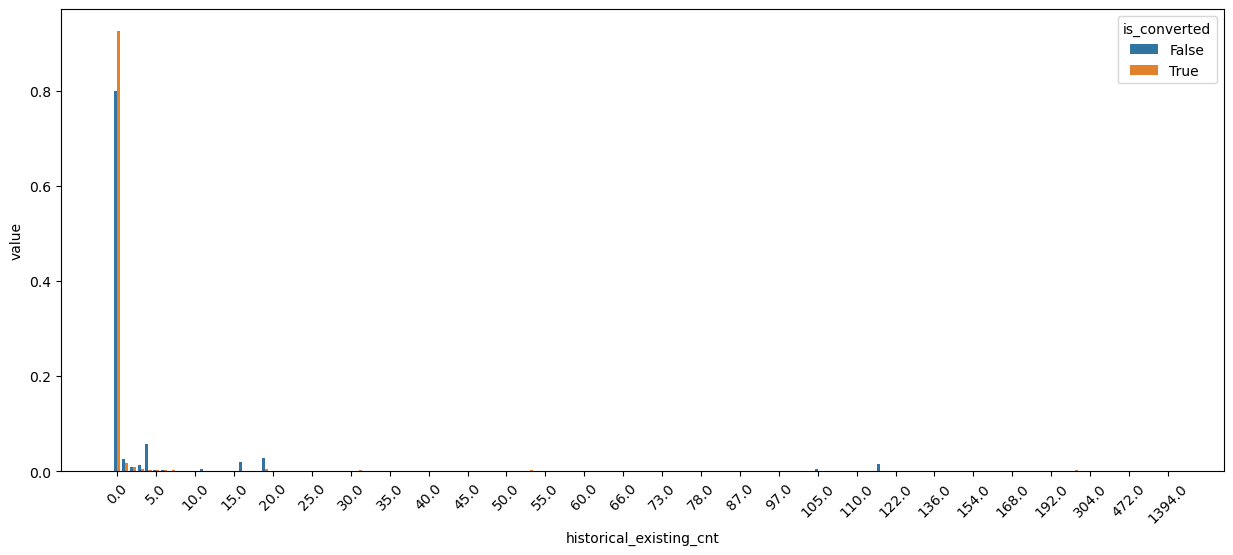

In [131]:
# 만약 결측치를 0으로 채운다면?
df = df_train.copy()
df.historical_existing_cnt = df_train.historical_existing_cnt.fillna(0)
df = pd.DataFrame(df.value_counts(["historical_existing_cnt", "is_converted"])).reset_index().pivot(index='is_converted', columns='historical_existing_cnt', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['historical_existing_cnt'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "historical_existing_cnt", y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(xlabels)/5)

plt.show()

### 변수 9~11. id_strategic_ver, it_strategic_ver, idit_strategic_ver
- 앞의 두 변수의 차이가 무엇인지 알수없음 -> 설명이 필요
- 두 변수가 전부 True인 곳이 없음
- idit_strategic_ver가 결측치라면 두 변수도 결측치 -> 전부 0으로 변환

In [132]:
print(set(df_train.id_strategic_ver.dropna()))
print(df_train.id_strategic_ver.isna().sum())

{1.0}
50922


In [133]:
print(set(df_train.it_strategic_ver.dropna()))
print(df_train.it_strategic_ver.isna().sum())

{1.0}
53029


In [134]:
print(set(df_train.idit_strategic_ver.dropna()))
print(df_train.idit_strategic_ver.isna().sum())

{1.0}
49835


In [135]:
# idit_strategic_ver가 NA이면 두 변수도 NA
df_train[df_train.idit_strategic_ver.isna()][["id_strategic_ver","it_strategic_ver"]].isna().sum()


id_strategic_ver    49835
it_strategic_ver    49835
dtype: int64

In [136]:
# 둘다 True인 경우가 없음
sum(df_train[df_train.idit_strategic_ver.notna()][["id_strategic_ver","it_strategic_ver"]].notna().sum(axis = 1) != 1)

0

In [137]:
df_train.id_strategic_ver = df_train.id_strategic_ver.fillna(0)
df_train.it_strategic_ver = df_train.it_strategic_ver.fillna(0)
df_train.idit_strategic_ver = df_train.idit_strategic_ver.fillna(0)

In [138]:
df_train.value_counts(["id_strategic_ver","it_strategic_ver", "idit_strategic_ver"])/len(df_train)

id_strategic_ver  it_strategic_ver  idit_strategic_ver
0.0               0.0               0.0                   0.920892
1.0               0.0               1.0                   0.059021
0.0               1.0               1.0                   0.020086
Name: count, dtype: float64

In [139]:
df = pd.DataFrame(df_train.value_counts(["id_strategic_ver", "is_converted"])).reset_index().pivot(index='is_converted', columns='id_strategic_ver', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df

is_converted,False,True
id_strategic_ver,,
0.0,0.941588,0.93424
1.0,0.058412,0.06576


In [140]:
df = pd.DataFrame(df_train.value_counts(["it_strategic_ver", "is_converted"])).reset_index().pivot(index='is_converted', columns='it_strategic_ver', values='count')
print(df)
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df

it_strategic_ver    0.0   1.0
is_converted                 
False             48555  1075
True               4474    12


is_converted,False,True
it_strategic_ver,,
0.0,0.97834,0.997325
1.0,0.02166,0.002675


In [141]:
df = pd.DataFrame(df_train.value_counts(["idit_strategic_ver", "is_converted"])).reset_index().pivot(index='is_converted', columns='idit_strategic_ver', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df

is_converted,False,True
idit_strategic_ver,,
0.0,0.919927,0.931565
1.0,0.080073,0.068435


### 변수 12. customer_job
- 고객의 직업군
- 결측치가 좀 있음 -> 약 30%
- 총 561개의 카테고리 -> 카테고리를 축소할 필요가 있음

In [167]:
df_train.customer_job.isna().sum()/len(df_train)

0.3046973168748614

In [168]:
len(set(df_train.customer_job))

560

In [170]:
translator = Translator()
start = time.time()
job_lst = set(df_train.customer_job)
job_lst_trans = [translator.translate(i, dest="en").text if not pd.isna(i) else i for i in job_lst] 
end = time.time()
end - start

177.4530267715454

In [171]:
job_dict = pd.DataFrame([job_lst, job_lst_trans]).T
job_dict.columns = ["job_lst", "job_lst_trans"]
job_dict = job_dict.set_index("job_lst").T.to_dict()

df_train.customer_job = [job_dict[i]["job_lst_trans"] if not pd.isna(i) else i for i in df_train.customer_job]

In [172]:
# other, others 통합
other = ["other", "others"]
df_train.customer_job = df_train.customer_job.replace(other, ['other']*len(other))


In [173]:
len(set(df_train.customer_job))

526

In [163]:
df = pd.DataFrame(df_train.value_counts(["customer_job", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_job', values='count')
df.T.sort_values(False, ascending = False)

is_converted,False,True
customer_job,,
engineering,5227.0,543.0
other,4811.0,264.0
administrative,2861.0,313.0
education,1992.0,194.0
sales,1935.0,134.0
...,...,...
liason,1.0,NaN
account exec/manager,NaN,1.0
design engineer,NaN,1.0


In [164]:
df.T.sort_values(True, ascending = False)

is_converted,False,True
customer_job,,
engineering,5227.0,543.0
information technology,1464.0,319.0
administrative,2861.0,313.0
purchasing,1555.0,267.0
other,4811.0,264.0
...,...,...
waiter,1.0,NaN
wall mounted screen mirroring,1.0,NaN
we are in iceland,1.0,NaN


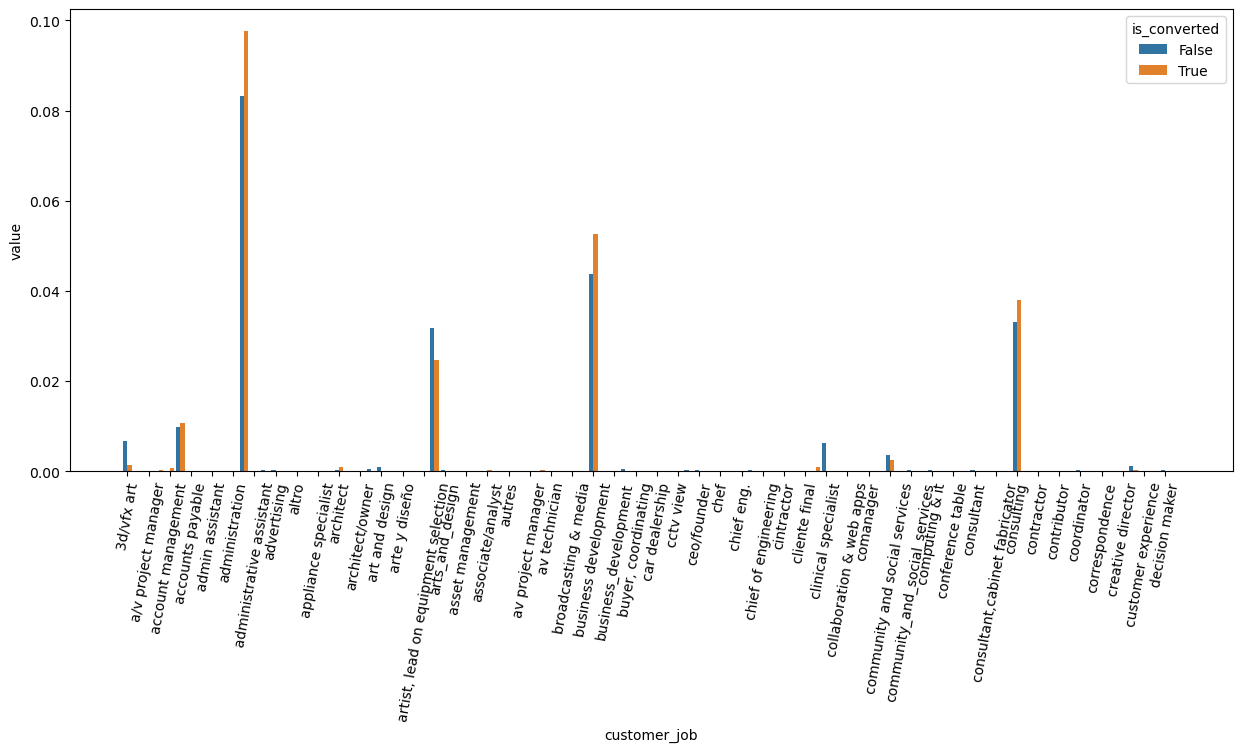

In [165]:
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0).iloc[0:100]
df = pd.melt(df.reset_index(), id_vars=['customer_job'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=80)
ax = sns.barplot(x= 'customer_job', y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(df_train)/1000)
plt.show()

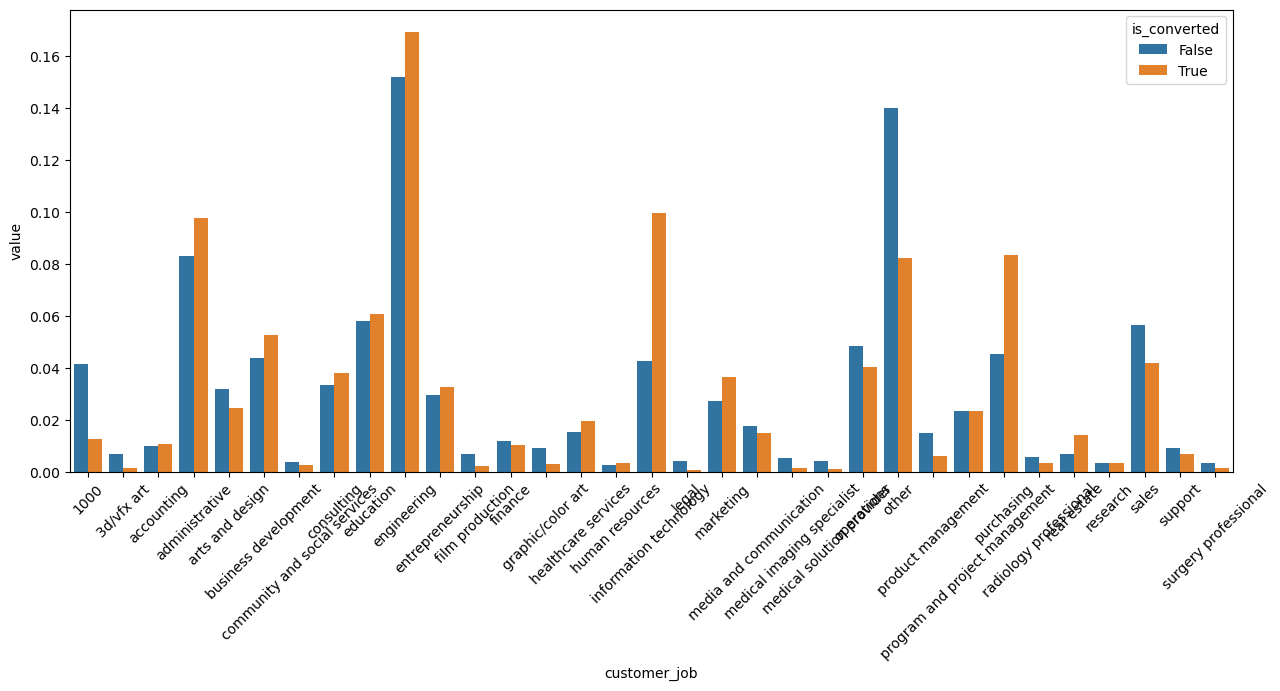

In [166]:
# total 갯수가 100 이하는 하나의 카테고리로 통합
df = df_train.copy()
idx = df_train.customer_job.value_counts()[df_train.customer_job.value_counts()>100].index
df.customer_job = [1000 if i not in idx and not pd.isna(i) else i for i in df.customer_job]

df = pd.DataFrame(df.value_counts(["customer_job", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_job', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).dropna()
df = pd.melt(df.reset_index(), id_vars=['customer_job'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "customer_job", y="value", hue = "is_converted", data = df)

plt.show()

### 변수 13. lead_desc_length
- 고객이 작성한 Lead Descriptoin 텍스트 총 길이
- 결측치 없음
- 텍스트 길이가 길수록 False 비율이 더 크다.
- 텍스트 길이가 짧으면 특히 50~450 사이에는 True의 비율이 더 큰 값이 많은데 엄청 비율이 큰 것은 아니다.

In [154]:
df_train.lead_desc_length.isna().sum()

0

In [155]:
len(set(df_train.lead_desc_length))

909

In [156]:
df = pd.DataFrame(df_train.value_counts(["lead_desc_length", "is_converted"])).reset_index().pivot(index='is_converted', columns='lead_desc_length', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df

is_converted,False,True
lead_desc_length,,
1,0.013903,0.000892
2,0.017086,0.001337
3,0.179790,0.087383
4,0.015213,0.004681
5,0.014507,0.003121
...,...,...
1168,0.000020,0.000000
1174,0.000040,0.000000
1181,0.000020,0.000000


In [159]:
print("{} ~ {} : {}".format(1, 30, sum(np.array(df[False]>df[True])[0:30])))
print("{} ~ {} : {}".format(1, 100, sum(np.array(df[False]>df[True])[0:100])))
print("{} ~ {} : {}".format(101, 200, sum(np.array(df[False]>df[True])[100:200])))
print("{} ~ {} : {}".format(201, 300, sum(np.array(df[False]>df[True])[200:300])))
print("{} ~ {} : {}".format(301, 400, sum(np.array(df[False]>df[True])[300:400])))
print("{} ~ {} : {}".format(401, 500, sum(np.array(df[False]>df[True])[400:500])))
print("{} ~ {} : {}".format(501, 600, sum(np.array(df[False]>df[True])[500:600])))
print("{} ~ {} : {}".format(601, 700, sum(np.array(df[False]>df[True])[600:700])))
print("{} ~ {} : {}".format(701, 800, sum(np.array(df[False]>df[True])[700:800])))
print("{} ~ {} : {}".format(801, 900, sum(np.array(df[False]>df[True])[800:900])))
print("{} ~ {} : {}".format(901, 909, sum(np.array(df[False]>df[True])[900:909])))

1 ~ 30 : 30
1 ~ 100 : 51
101 ~ 200 : 7
201 ~ 300 : 12
301 ~ 400 : 23
401 ~ 500 : 39
501 ~ 600 : 58
601 ~ 700 : 74
701 ~ 800 : 79
801 ~ 900 : 84
901 ~ 909 : 9


In [160]:
print("{} ~ {} : {}".format(1, 30, sum(np.array(df[False]+0.01<df[True])[0:30])))
print("{} ~ {} : {}".format(1, 100, sum(np.array(df[False]+0.01<df[True])[0:100])))
print("{} ~ {} : {}".format(101, 200, sum(np.array(df[False]+0.01<df[True])[100:200])))
print("{} ~ {} : {}".format(201, 300, sum(np.array(df[False]+0.01<df[True])[200:300])))
print("{} ~ {} : {}".format(301, 400, sum(np.array(df[False]+0.01<df[True])[300:400])))
print("{} ~ {} : {}".format(401, 500, sum(np.array(df[False]+0.01<df[True])[400:500])))
print("{} ~ {} : {}".format(501, 600, sum(np.array(df[False]+0.01<df[True])[500:600])))
print("{} ~ {} : {}".format(601, 700, sum(np.array(df[False]+0.01<df[True])[600:700])))
print("{} ~ {} : {}".format(701, 800, sum(np.array(df[False]+0.01<df[True])[700:800])))
print("{} ~ {} : {}".format(801, 900, sum(np.array(df[False]+0.01<df[True])[800:900])))
print("{} ~ {} : {}".format(901, 909, sum(np.array(df[False]+0.01<df[True])[900:909])))

1 ~ 30 : 0
1 ~ 100 : 0
101 ~ 200 : 0
201 ~ 300 : 0
301 ~ 400 : 0
401 ~ 500 : 0
501 ~ 600 : 0
601 ~ 700 : 0
701 ~ 800 : 0
801 ~ 900 : 0
901 ~ 909 : 0


In [161]:
text_len = pd.cut(df_train.lead_desc_length, [0, 50, 100, 200, 300, 400, 500, 600])

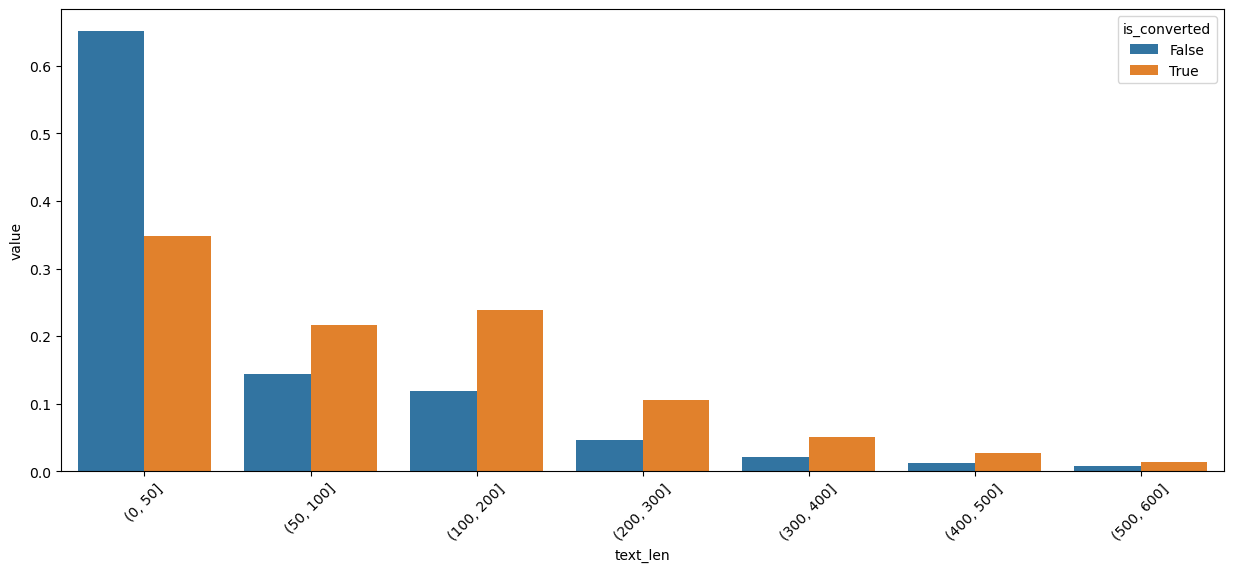

In [162]:
df = df_train.copy()
df["text_len"] = text_len
df = pd.DataFrame(df.value_counts(["text_len", "is_converted"])).reset_index().pivot(index='is_converted', columns='text_len', values='count')

df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['text_len'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
sns.barplot(x= 'text_len', y="value", hue = "is_converted", data = df)

plt.show()

### 변수 14. inquiry_type
- 고객의 문의 유형
- 총 72개의 카테고리 -> 특수문자 제거 및 비슷한 카테고리 결합, 총합 30 이하의 카테고리 etc로 결합하는 과정 -> 총 12개 카테고리
- quotation or purchase consultation의 경우는 True의 비율이 더 높고, 나머지는 False가 높다.

In [163]:
df_train.inquiry_type.isna().sum()

886

In [164]:
len(set(df_train.inquiry_type))

72

In [65]:
inquiry_lst = list(set(df_train.inquiry_type))
re_inquiry_lst = [translator.translate(i, dest="en").text if not pd.isna(i) else i for i in inquiry_lst] 
re_inquiry_lst = [re.sub(r"[.,~!@#$%^&*\(\)_+=\-~|\\\"\';:\?/\<\>\[\]\{\}]", " ", inquiry) if not pd.isna(inquiry) else inquiry for inquiry in re_inquiry_lst]
re_inquiry_lst = [' '.join(inquiry.split()) if not pd.isna(inquiry) else inquiry for inquiry in re_inquiry_lst]
re_inquiry_lst = [inquiry.strip().lower() if not pd.isna(inquiry) else inquiry for inquiry in re_inquiry_lst]

NameError: name 'translator' is not defined

In [166]:
re_inquiry_dict = pd.DataFrame([inquiry_lst, re_inquiry_lst]).T
re_inquiry_dict.columns = ["inquiry_lst", "re_inquiry_lst"]
re_inquiry_dict = re_inquiry_dict.set_index("inquiry_lst").T.to_dict()

df_train.inquiry_type = [re_inquiry_dict[i]["re_inquiry_lst"] if not pd.isna(i) else i for i in df_train.inquiry_type]

In [167]:
len(set(df_train.inquiry_type))

60

In [168]:
# quotation or purchase consultation, request for quotation or purchase, purchase or quotation , purchase, quotation 결합
# other, others, etc 결합                                                                                           
# usage or technical consultation, technical consultation, technical support, request for technical consulting, technical 결합
qp = ['quotation or purchase consultation', 'request for quotation or purchase','purchase or quotation' , 'purchase', 'quotation']
df_train.inquiry_type = df_train.inquiry_type.replace(qp, ['quotation or purchase consultation']*len(qp))

etc = ['other', 'others', 'etc']
df_train.inquiry_type = df_train.inquiry_type.replace(etc, ['etc']*len(etc))

tech = ['usage or technical consultation', 'technical consultation', 'technical support', 'request for technical consulting', 'technical']
df_train.inquiry_type = df_train.inquiry_type.replace(tech, ['usage or technical consultation']*len(tech))

less = df_train.inquiry_type.value_counts()[df_train.inquiry_type.value_counts()<30].index
df_train.inquiry_type = df_train.inquiry_type.replace(less, ['etc']*len(less))

In [169]:
len(set(df_train.inquiry_type))

12

In [170]:
df_train.inquiry_type.value_counts()

inquiry_type
quotation or purchase consultation    39024
sales inquiry                          8775
usage or technical consultation        1604
etc                                    1417
product information                    1090
trainings                               369
services                                350
request for partnership                 265
request a demo                          169
sales                                   100
request for distributorship              67
Name: count, dtype: int64

In [171]:
df = pd.DataFrame(df_train.value_counts(["inquiry_type", "is_converted"])).reset_index().pivot(index='is_converted', columns='inquiry_type', values='count')
df.T

is_converted,False,True
inquiry_type,,
etc,1367,50
product information,1080,10
quotation or purchase consultation,35445,3579
request a demo,163,6
request for distributorship,64,3
request for partnership,235,30
sales,98,2
sales inquiry,8224,551
services,340,10


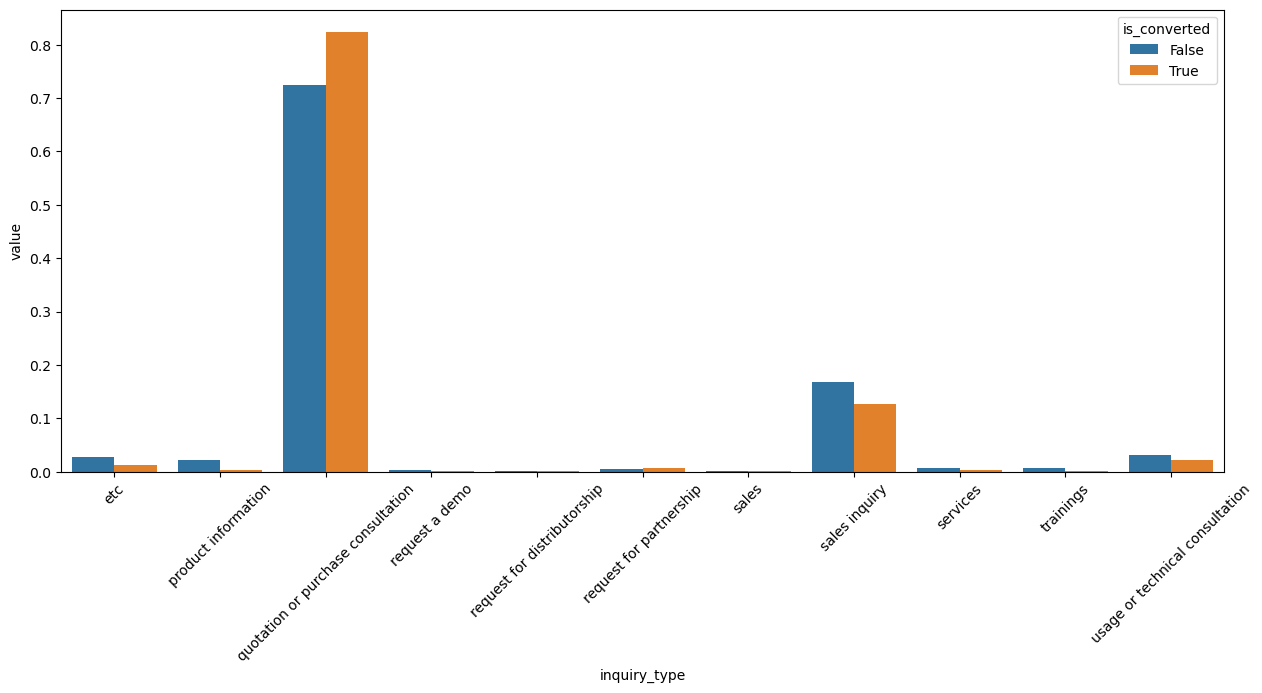

In [172]:
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['inquiry_type'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
sns.barplot(x= 'inquiry_type', y="value", hue = "is_converted", data = df)

plt.show()

### 변수 15. product_category
- 요청 제품 카테고리
- 결측치가 있음 -> 약 31%
- 갯수가 50개 미만인 카테고리를 etc로 통합한 경우 총 카테고리 수는 42개

In [180]:
df_train.product_category.isna().sum()/len(df_train)

0.31179318500997855

In [174]:
product_lst = list(set(df_train.product_category))
re_product_lst = [translator.translate(i, dest="en").text if not pd.isna(i) else i for i in product_lst] 
re_product_dict = pd.DataFrame([product_lst, re_product_lst]).T
re_product_dict.columns = ["product_lst", "re_product_lst"]
re_product_dict = re_product_dict.set_index("product_lst").T.to_dict()

df_train.product_category = [re_product_dict[i]["re_product_lst"] if not pd.isna(i) else i for i in  df_train.product_category]

etc = ['other', 'others', 'etc', 'etc.']
df_train.product_category = df_train.product_category.replace(etc, ['etc']*len(etc))

In [175]:
len(set(df_train.product_category))

339

In [176]:
product_count = df_train.product_category.value_counts()
less = product_count[product_count<50].index
product_less = df_train.product_category.replace(less, ['etc']*len(less))

In [177]:
len(set(product_less))

42

In [178]:
df = df_train.copy()
df.product_category = product_less
df = pd.DataFrame(df.value_counts(["product_category", "is_converted"])).reset_index().pivot(index='is_converted', columns='product_category', values='count')
df.T.sort_values(True, ascending = False)

is_converted,False,True
product_category,,
vrf,4562.0,509.0
video wall signage,1518.0,349.0
multi-split,3179.0,314.0
interactive signage,1437.0,304.0
led signage,1420.0,297.0
etc,3005.0,280.0
hotel tv,774.0,253.0
interactive digital board,5767.0,244.0
standard signage,746.0,150.0


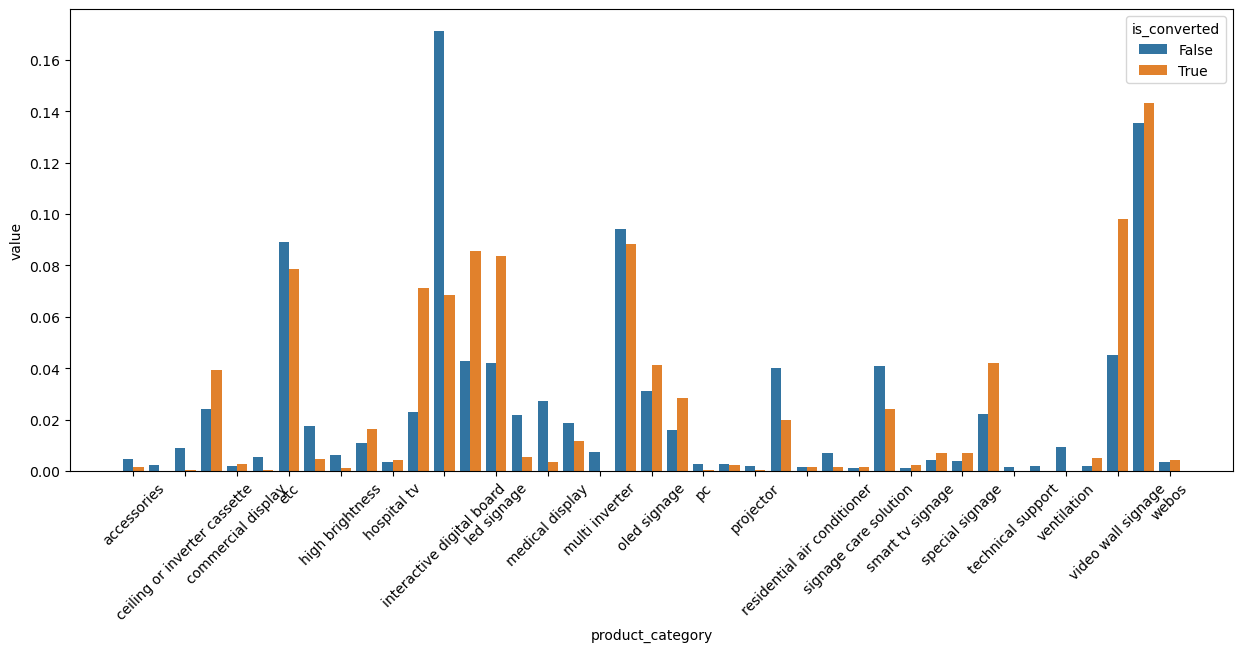

In [179]:
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['product_category'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= 'product_category', y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(xlabels)/5)
plt.show()

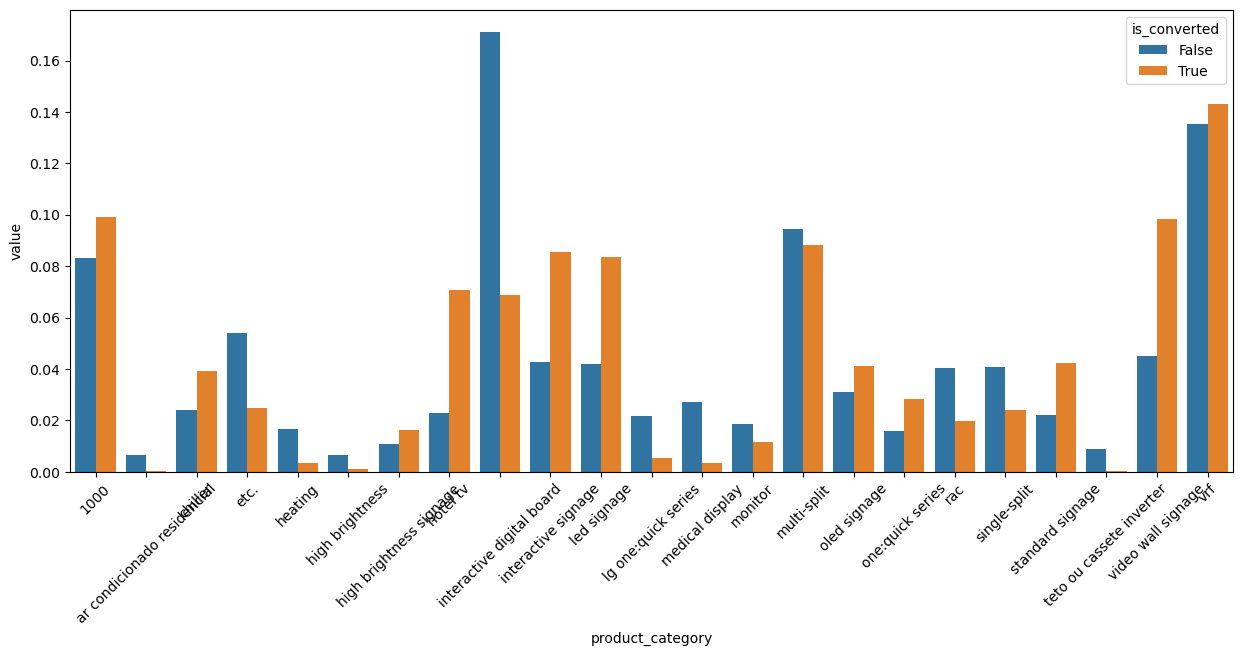

In [176]:
# total 갯수가 100 이하는 하나의 카테고리로 통합
df = df_train.copy()
idx = df_train.product_category.value_counts()[df_train.product_category.value_counts()>200].index
df.product_category = [1000 if i not in idx and not pd.isna(i) else i for i in df.product_category]

df = pd.DataFrame(df.value_counts(["product_category", "is_converted"])).reset_index().pivot(index='is_converted', columns='product_category', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).dropna()
df = pd.melt(df.reset_index(), id_vars=['product_category'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "product_category", y="value", hue = "is_converted", data = df)

plt.show()

### 변수 16. product_subcategory
- 요청 제품 하위 카테고리
- 결측치가 많음 -> 84%

In [22]:
df_train.product_subcategory.isna().sum()/len(df_train)

0.8421169339936433

In [25]:
len(set(df_train.product_subcategory))

331

In [29]:
translator = Translator()
subcategory_lst = list(set(df_train.product_subcategory))
re_subcategory_lst = [translator.translate(i, dest="en").text if not pd.isna(i) else i for i in subcategory_lst] 
re_subcategory_lst = [subcategory.strip().lower() if not pd.isna(subcategory) else subcategory for subcategory in re_subcategory_lst]

re_subcategory_dict = pd.DataFrame([subcategory_lst, re_subcategory_lst]).T
re_subcategory_dict.columns = ["subcategory_lst", "re_subcategory_lst"]
re_subcategory_dict = re_subcategory_dict.set_index("subcategory_lst").T.to_dict()

df_train.product_subcategory = [re_subcategory_dict[i]["re_subcategory_lst"] if not pd.isna(i) else i for i in df_train.product_subcategory]

In [30]:
len(set(df_train.product_subcategory))

306

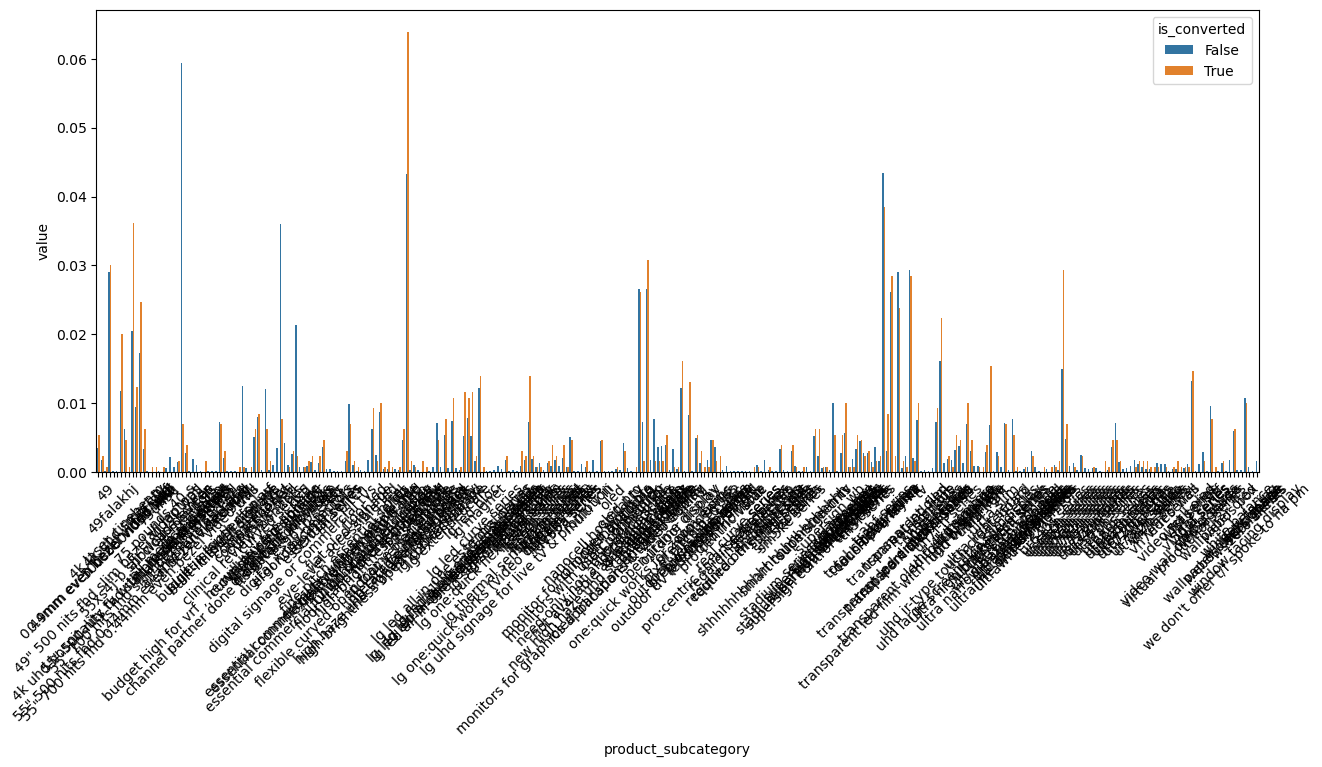

In [39]:
df = pd.DataFrame(df_train.value_counts(["product_subcategory", "is_converted"])).reset_index().pivot(index='is_converted', columns='product_subcategory', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['product_subcategory'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
sns.barplot(x= 'product_subcategory', y="value", hue = "is_converted", data = df)

plt.show()

In [56]:
df = pd.DataFrame(df_train.value_counts(["product_subcategory", "is_converted"])).reset_index().pivot(index='is_converted', columns='product_subcategory', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)

In [57]:
abs(df[False] - df[True]).sort_values(ascending = False)

product_subcategory
all medical displays                             0.052547
diagnostic monitors                              0.028316
interactive digital board                        0.020610
digital x-ray detectors                          0.019080
55" 500 nits fhd 0.44mm even bezel video wall    0.015784
                                                   ...   
supersign simple editor                          0.000080
lu766a series                                    0.000080
pro:centric smart                                0.000070
smart touch screen tv                            0.000058
ultra high brightness series                     0.000058
Length: 305, dtype: float64

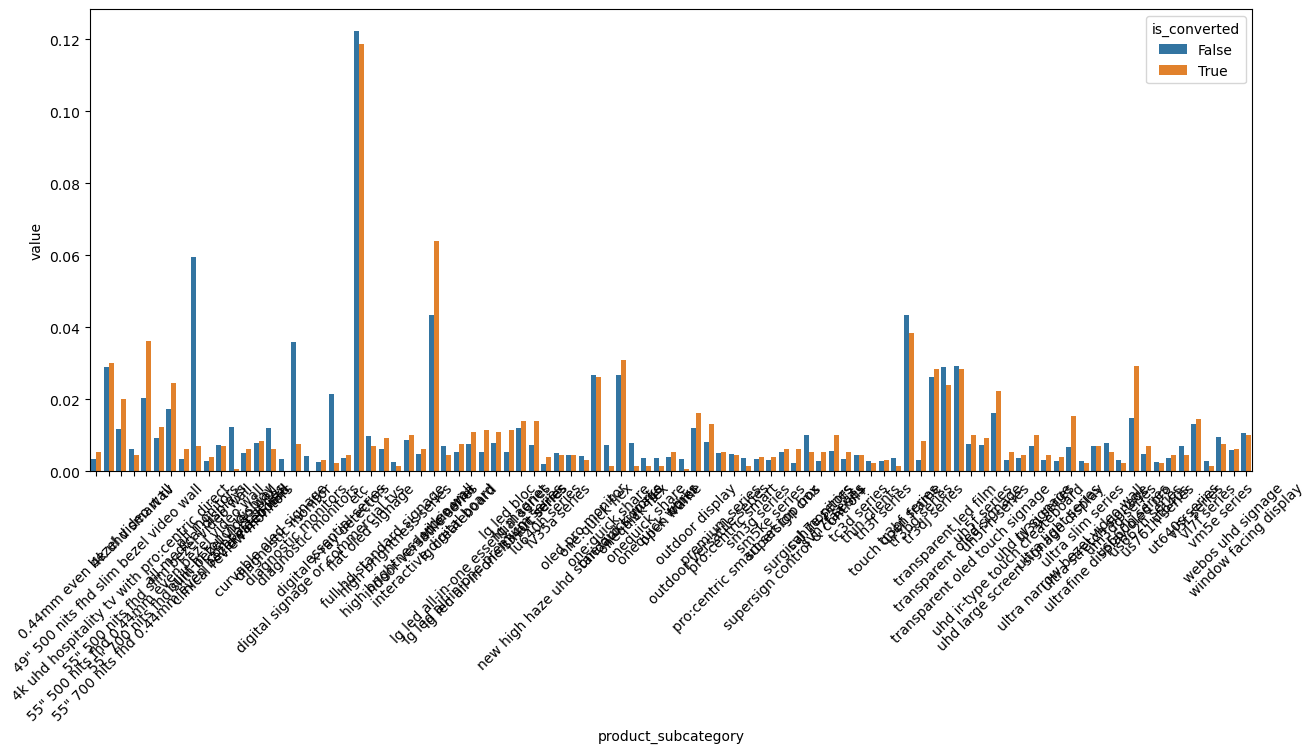

In [74]:
product_count = df_train.product_subcategory.value_counts()
less = product_count[product_count<20].index
product_less = df_train.product_subcategory.replace(less, ['etc']*len(less))

df = df_train.copy()
df.product_subcategory = product_less
df = pd.DataFrame(df.value_counts(["product_subcategory", "is_converted"])).reset_index().pivot(index='is_converted', columns='product_subcategory', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['product_subcategory'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
sns.barplot(x= 'product_subcategory', y="value", hue = "is_converted", data = df)

plt.show()

### 변수 17. product_modelname
- 	요청 제품 모델명
- 결측치가 많음 -> 84%
- UltraFine Ergo(32UN880), 28MQ780, All Medical Displays가 수가 가장 많은데 전부 False

In [76]:
df_train.product_modelname.isna().sum()/len(df_train)

0.8398255599083451

In [79]:
len(set(df_train.product_modelname))

666

In [93]:
df_train.product_modelname.value_counts().sort_values(ascending = False)

product_modelname
UltraFine Ergo(32UN880)    519
28MQ780                    471
All Medical Displays       348
43HT3WJ                    275
55CT5WJ                    252
                          ... 
16T90P                       1
LAP025EP                     1
55UT662M (MEA)               1
65US765H (ASIA)              1
55US660H (SCA)               1
Name: count, Length: 665, dtype: int64

In [83]:
df = pd.DataFrame(df_train.value_counts(["product_modelname", "is_converted"])).reset_index().pivot(index='is_converted', columns='product_modelname', values='count')
df.T.sort_values(False, ascending = False)

is_converted,False,True
product_modelname,,
UltraFine Ergo(32UN880),519.0,NaN
28MQ780,471.0,NaN
All Medical Displays,348.0,NaN
43HT3WJ,241.0,34.0
55CT5WJ,210.0,42.0
...,...,...
GSEH080,NaN,1.0
LDAA025-1,NaN,1.0
One:Quick,NaN,1.0


In [88]:
df = pd.DataFrame(df_train.value_counts(["product_modelname", "is_converted"])).reset_index().pivot(index='is_converted', columns='product_modelname', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df.sort_values(False, ascending = False)

is_converted,False,True
product_modelname,,
UltraFine Ergo(32UN880),0.068524,0.000000
28MQ780,0.062186,0.000000
All Medical Displays,0.045947,0.000000
43HT3WJ,0.031819,0.031079
55CT5WJ,0.027726,0.038391
...,...,...
50UR640S (MEA),0.000000,0.000914
"APNQ100LFT0, APUQ100LFT0",0.000000,0.000914
GSCD100-GR3,0.000000,0.000914


### 변수 17. customer_position
- 고객의 회사 직책
- 결측치 없음
- 직책에 따른 차이는 없어보임

In [89]:
df_train.customer_position.isna().sum()

0

In [94]:
len(set(df_train.customer_position))

117

In [177]:
position_lst = list(set(df_train.customer_position))
re_position_lst = [translator.translate(i, dest="en").text if not pd.isna(i) else i for i in position_lst] 
re_position_lst = [re.sub(r"[.,~!@#$%^&*\(\)_+=\-~|\\\"\';:\?/\<\>\[\]\{\}]", " ", position) if not pd.isna(position) else position for position in re_position_lst]
re_position_lst = [''.join(position.split()) if not pd.isna(position) else position for position in re_position_lst]
re_position_lst = [position.strip().lower() if not pd.isna(position) else position for position in re_position_lst]

In [178]:
re_position_dict = pd.DataFrame([position_lst, re_position_lst]).T
re_position_dict.columns = ["position_lst", "re_position_lst"]
re_position_dict = re_position_dict.set_index("position_lst").T.to_dict()

df_train.customer_position = [re_position_dict[i]["re_position_lst"] if not pd.isna(i) else i for i in df_train.customer_position]

In [179]:
ac = ['architectconsultant', 'architectureconsult']
df_train.customer_position = df_train.customer_position.replace(ac, ['architecture']*len(ac))

assistantprofessor = ['assistantprofessor', 'assistantprofessorofenglish', 'associateanalyst', 'associateprofessor', 'associateprofessorinelectronicsengg']
df_train.customer_position = df_train.customer_position.replace(assistantprofessor, ['assistantprofessor']*len(assistantprofessor))

business = ['businessdevelopment', 'businessdevelopmentsales']
df_train.customer_position = df_train.customer_position.replace(business, ['businessdevelopment']*len(business))

consultant = ['consultant','consulting']
df_train.customer_position = df_train.customer_position.replace(consultant, ['consultant']*len(consultant))

decision = ['decisioninfluencer', 'decisionmaker']
df_train.customer_position = df_train.customer_position.replace(decision, ['decision']*len(decision))

educator = ['education', 'educationprofessional', 'educator']
df_train.customer_position = df_train.customer_position.replace(educator, ['educator']*len(educator))

exhibition = ['exhibition', 'exhibitiontv']
df_train.customer_position = df_train.customer_position.replace(exhibition, ['exhibition']*len(exhibition))

prof = ['prof', 'professionaltrainer', 'professor', 'professorofmathematics']
df_train.customer_position = df_train.customer_position.replace(prof, ['prof']*len(prof))

teacher = ['teacher', 'teachermiddleschoolcoordinator', 'technical', 'technician', 'scienceteacher', 'mathandphysicsteacher', 'physicsteacher']
df_train.customer_position = df_train.customer_position.replace(teacher, ['teacher']*len(teacher))

other = ['other', 'otherpleasespecifycediaassociation', 'others']
df_train.customer_position = df_train.customer_position.replace(other, ['other']*len(other))


In [180]:
len(set(df_train.customer_position))

88

In [181]:
df = pd.DataFrame(df_train.value_counts(["customer_position", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_position', values='count')
df.T.sort_values(False, ascending = False)

is_converted,False,True
customer_position,,
none,15825.0,1393.0
ceofounder,6817.0,631.0
manager,6782.0,805.0
other,6460.0,419.0
director,4156.0,419.0
...,...,...
commercialconsultant,NaN,1.0
guestfaculty,NaN,1.0
noinfluence,NaN,2.0


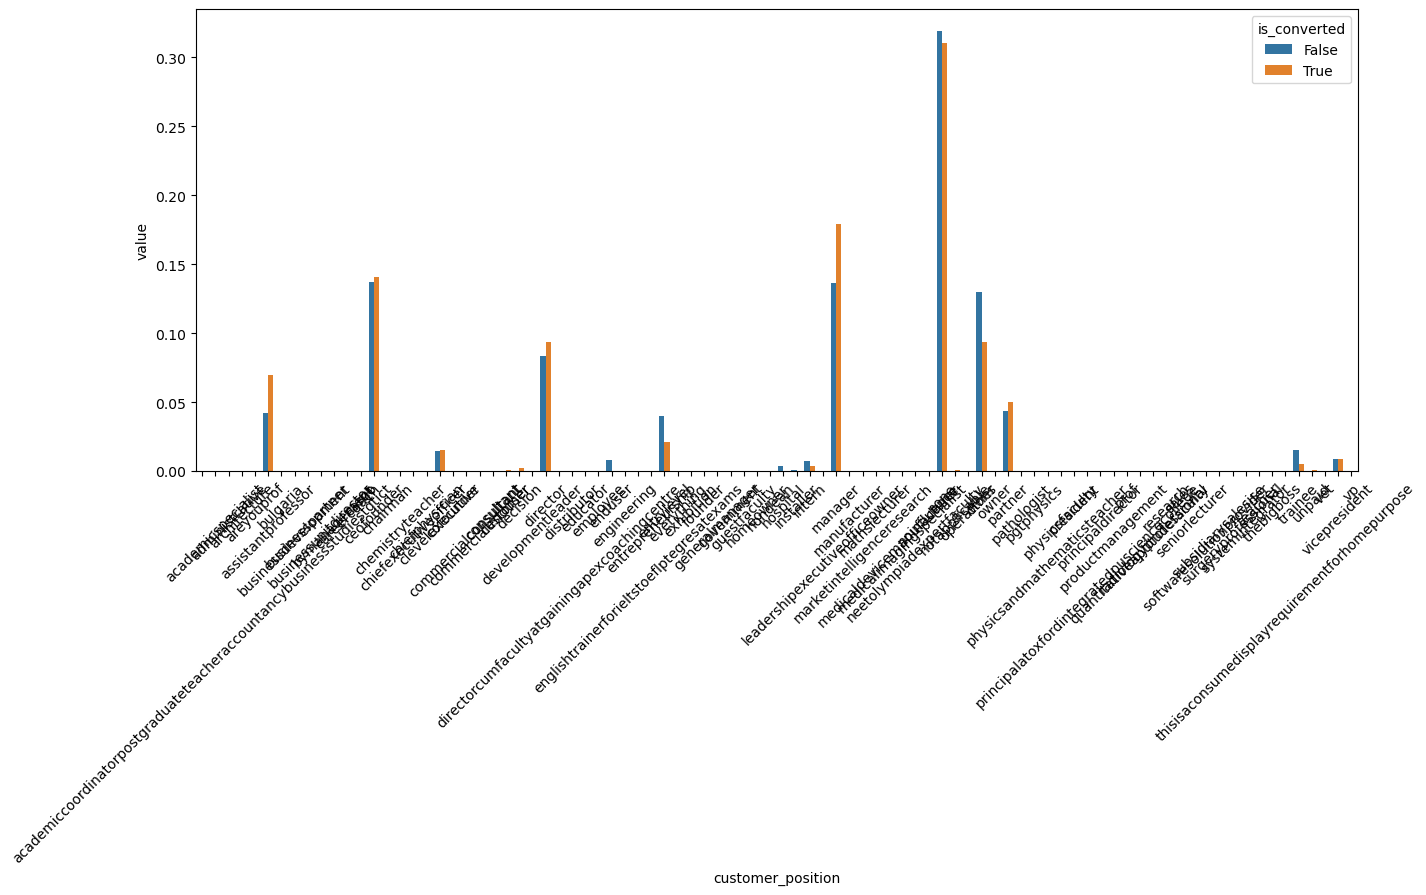

In [182]:
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['customer_position'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
sns.barplot(x= 'customer_position', y="value", hue = "is_converted", data = df)

plt.show()

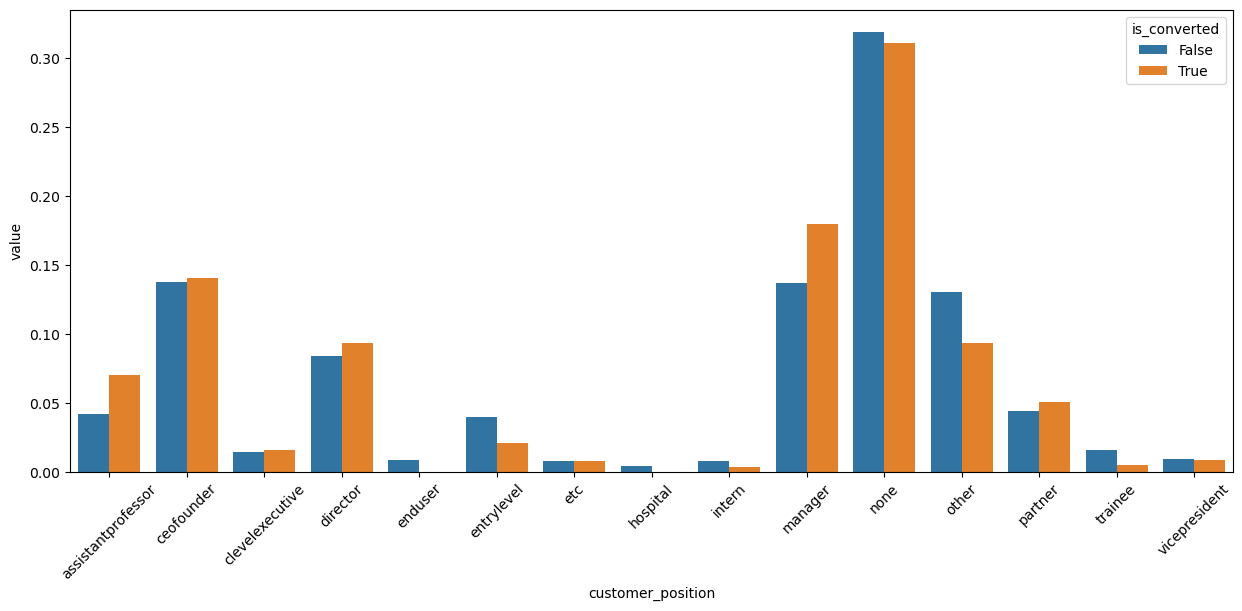

In [184]:
# 총 시도 횟수가 100 이하인 카테고리 결합
position_count = df_train.customer_position.value_counts()
less = position_count[position_count<100].index
position_less = df_train.customer_position.replace(less, ['etc']*len(less))

df = df_train.copy()
df.customer_position = position_less
df = pd.DataFrame(df.value_counts(["customer_position", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_position', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['customer_position'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
sns.barplot(x= 'customer_position', y="value", hue = "is_converted", data = df)

plt.show()

In [194]:
df.T[df.T.index == "hospital"]

is_converted,False,True
customer_position,,
hospital,199.0,NaN


In [190]:
df = pd.DataFrame(df_train.value_counts(["customer_position", "is_converted"])).reset_index().pivot(index='is_converted', columns='customer_position', values='count')

df.T.sort_values(True, ascending = False).tail(10)

is_converted,False,True
customer_position,,
sales,1.0,NaN
seniorlecturer,1.0,NaN
softwaresolutionprovider,25.0,NaN
subsidiarysalesise,1.0,NaN
surgeryprofessional,1.0,NaN
systemintegrator,21.0,NaN
thebigboss,1.0,NaN
thisisaconsumedisplayrequirementforhomepurpose,1.0,NaN
vet,1.0,NaN


### 변수 18. response_corporate
- 담당 자사 법인명
- 결측치 없음
- 몇 국가가 자사를 기준으로 그룹화되는지 확인 -> 아님
- LGEIS, LGEKR와 같은 자사들이 False는 400개 이상이지만 True는 너무 적어 확인해보았으나 해당하는 데이터 갯수가 너무 적어 사용할 수 없을 것 같음

In [196]:
df_train.response_corporate.isna().sum()

0

In [197]:
len(set(df_train.response_corporate))

53

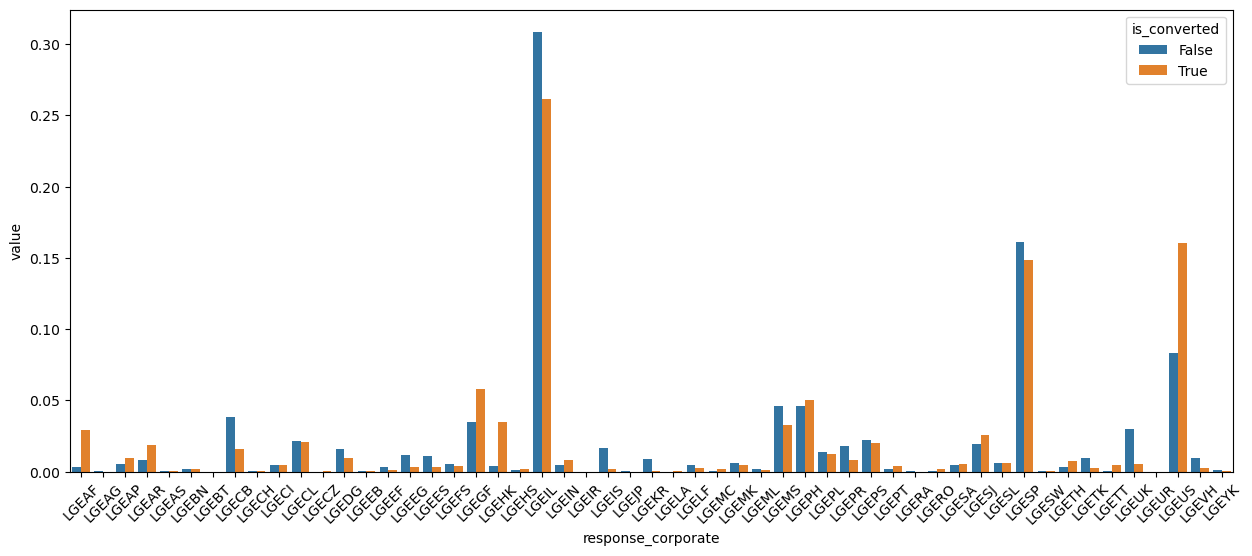

In [165]:
df = pd.DataFrame(df_train.value_counts(["response_corporate", "is_converted"])).reset_index().pivot(index='is_converted', columns='response_corporate', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['response_corporate'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
sns.barplot(x= 'response_corporate', y="value", hue = "is_converted", data = df)

plt.show()

### 변수 19. expected_timeline
- 고객의 요청한 처리 일정

In [171]:
df_train.expected_timeline.isna().sum()

27693

In [181]:
time = ['09-02-2022 requested for boq of requirement',
 '14:00~15:00',
 '14th aug- aggressive price required as he has got price from outside delhi',
 '14th-feb-2022 shared details.awaiting update from customer.',
 '25-nov-2021  no mobile number, sent a mail to customer',
 '29thsep2021:-no such requirement as of now',
 '3 months',
 '3 months ~ 6 months',
 '3_months_~_6_months',
 '4/8 months',
 '45 days',
 '6 months ~ 9 months',
 '6_months_~_9_months',
 '9 months - 1 year',
 '9 months ~ 1 year',
 '9_months_~_1_year',
    'december 2022',
    'september',
 'september 2022',
 'november 2022',
 'november 22',
 'october 2022',
    'less than 3 months',
 'less than 3 months ,meeting with the customer for the more details and tentative boq will ne 32 and 43',
 'less than 3 months- outdoor led requiment',
 'less than 3 months. customer not answered . to call back',
 'less than 5 months',
 'less than 6 months',
 'less then 6 months',
 'less_than_3_months']
text = list(set(df_train.expected_timeline) - set(time))

In [186]:
df = df_train.copy()
df.expected_timeline = df.expected_timeline.replace(time, ['time']*len(time))
df.expected_timeline = df.expected_timeline.replace(text, ['text']*len(text))


In [187]:
df = pd.DataFrame(df.value_counts(["expected_timeline", "is_converted"])).reset_index().pivot(index='is_converted', columns='expected_timeline', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df.T

expected_timeline,text,time
is_converted,,
False,0.582893,0.417107
True,0.507579,0.492421


### 변수 20, 21. ver_cus, ver_pro
- 특정 Vertical Level 1(사업영역) 이면서 Customer_type(고객 유형)이 소비자(End-user)인 경우에 대한 가중치
- 특정 Vertical Level 1(사업영역) 이면서 특정 Product Category(제품 유형)인 경우에 대한 가중치
- 결측치는 없는데 이 변수를 왜 만들어둔 것인지 이해가 불가능

In [197]:
df_train.ver_cus.value_counts()

ver_cus
0    52029
1     2087
Name: count, dtype: int64

In [189]:
df_train.ver_cus.isna().sum()

0

In [190]:
set(df_train.ver_cus)

{0, 1}

In [191]:
df = pd.DataFrame(df_train.value_counts(["ver_cus", "is_converted"])).reset_index().pivot(index='is_converted', columns='ver_cus', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df.T

ver_cus,0,1
is_converted,,
False,0.965344,0.034656
True,0.918190,0.081810


In [192]:
df_train.ver_pro.isna().sum()

0

In [193]:
set(df_train.ver_pro)

{0, 1}

In [194]:
df = pd.DataFrame(df_train.value_counts(["ver_pro", "is_converted"])).reset_index().pivot(index='is_converted', columns='ver_pro', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df.T

ver_pro,0,1
is_converted,,
False,0.949990,0.050010
True,0.943379,0.056621


### 변수 22. ver_win_ratio_per_bu
- 특정 Vertical Level1의 Business Unit 별 샘플 수 대비 영업 전환된 샘플 수의 비율을 계산 -> 데이터 해석에 주의
- 특정 Vertical Level1 변수 생성 -> 특정 사업영역이 아닐 때가 True의 비율이 더 높음


In [195]:
df_train.ver_win_ratio_per_bu.isna().sum()

39882

In [206]:
df_train.ver_win_ratio_per_bu.isna().sum()

39882

In [210]:
set(df_train.ver_win_ratio_per_bu.dropna())

{0.0115830115830115,
 0.0201207243460764,
 0.022633744855967,
 0.0227272727272727,
 0.0268456375838926,
 0.0287769784172661,
 0.031578947368421,
 0.0344827586206896,
 0.0354838709677419,
 0.0369127516778523,
 0.048629531388152,
 0.0498402555910543,
 0.0514705882352941,
 0.0535714285714285,
 0.0609243697478991,
 0.0640703517587939,
 0.0645661157024793,
 0.071345029239766,
 0.0794117647058823,
 0.1285714285714285,
 0.1311475409836065,
 0.2272727272727272,
 0.2857142857142857}

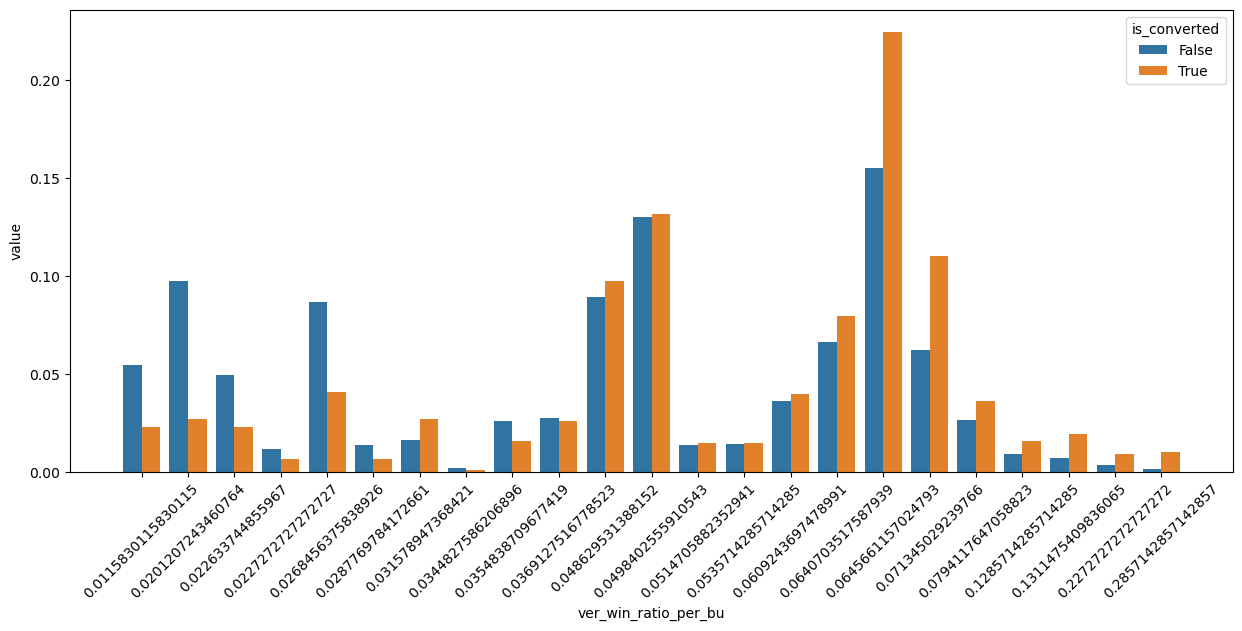

In [212]:
df = df_train.copy()
df = pd.DataFrame(df.value_counts(["ver_win_ratio_per_bu", "is_converted"])).reset_index().pivot(index='is_converted', columns='ver_win_ratio_per_bu', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['ver_win_ratio_per_bu'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "ver_win_ratio_per_bu", y="value", hue = "is_converted", data = df)
ax.locator_params(axis='x', nbins=len(df_train)/5)

plt.show()

In [214]:
# 특정 사업영역 변수 생성
vertical = [0 if pd.isna(i) else 1 for i in df_train.ver_win_ratio_per_bu]
df = df_train.copy()
df["vertical"] = vertical
df = pd.DataFrame(df.value_counts(["vertical", "is_converted"])).reset_index().pivot(index='is_converted', columns='vertical', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df.T

vertical,0,1
is_converted,,
False,0.730969,0.269031
True,0.803388,0.196612


### 변수 23. business_area
- 고객의 사업 영역
- hospital & health care 의 True 비율이 유독 높음

In [240]:
df_train.business_area.isna().sum()/len(df_train)

0.6854719491462784

In [216]:
set(df_train.business_area)

{'corporate / office',
 'education',
 'factory',
 'government department',
 'hospital & health care',
 'hotel & accommodation',
 nan,
 'power plant / renewable energy',
 'public facility',
 'residential (home)',
 'retail',
 'special purpose',
 'transportation'}

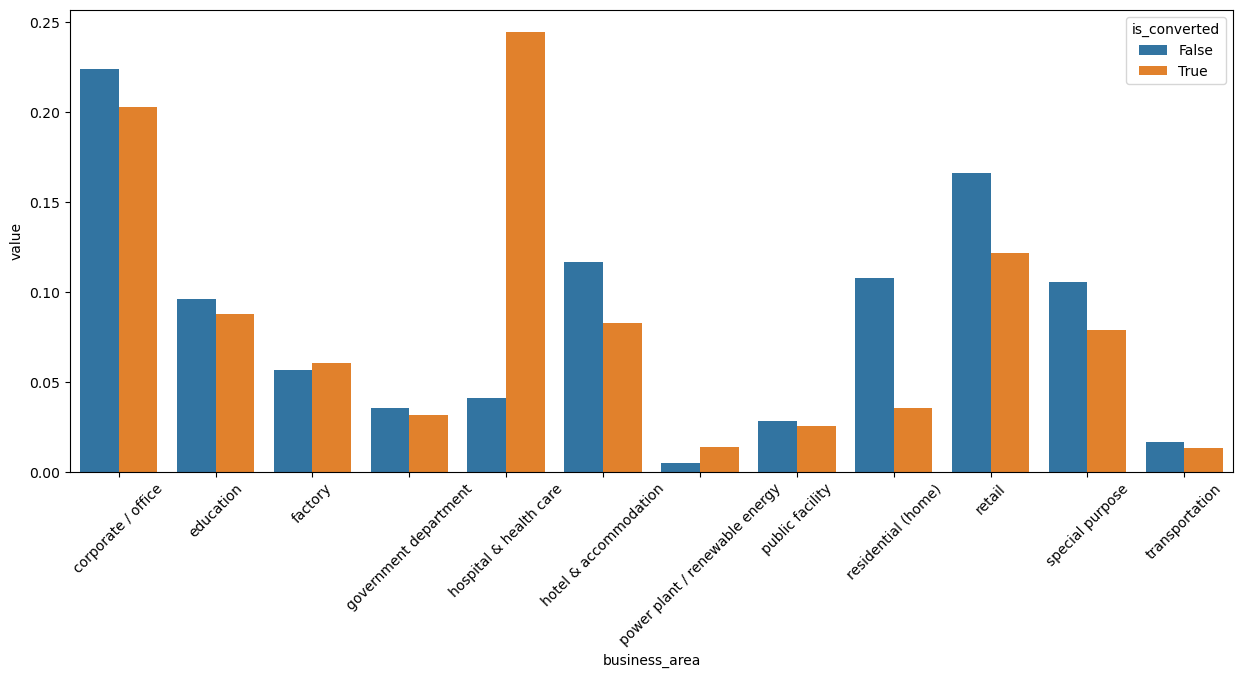

In [218]:
df = pd.DataFrame(df_train.value_counts(["business_area", "is_converted"])).reset_index().pivot(index='is_converted', columns='business_area', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1]).fillna(0)
df = pd.melt(df.reset_index(), id_vars=['business_area'], value_vars=[False, True])

fig,ax = plt.subplots(figsize=(15,6))
plt.xticks(rotation=45)
ax = sns.barplot(x= "business_area", y="value", hue = "is_converted", data = df)

plt.show()

In [241]:
df_train.business_subarea.isna().sum()/len(df_train)

0.9139995565082416

### 변수 24. lead_owner
- 영업 담당자 이름
- 결측치 없음
- 몇몇 담당자들은 False의 비율이 엄청 큼

In [244]:
df_train.lead_owner.isna().sum()/len(df_train)

0.0

In [252]:
df = pd.DataFrame(df_train.value_counts(["lead_owner", "is_converted"])).reset_index().pivot(index='is_converted', columns='lead_owner', values='count')
df["total"] = df.sum(axis = 1)
df = pd.DataFrame([df[i]/df.total for i in df.columns.drop("total")], index = df.columns[:-1])
df.sort_values(False, ascending = False)

is_converted,False,True
lead_owner,,
174,0.089422,0.010031
175,0.082370,NaN
23,0.045114,0.006910
97,0.043804,NaN
194,0.040862,NaN
...,...,...
1008,NaN,0.000223
1030,NaN,0.000446
1041,NaN,0.000223


In [253]:
df.sort_values(True, ascending = False)

is_converted,False,True
lead_owner,,
487,0.005742,0.026081
480,0.000947,0.021400
437,0.000101,0.018948
279,0.004231,0.016050
68,0.005118,0.015158
...,...,...
1106,0.000020,NaN
1109,0.000020,NaN
1110,0.000020,NaN


In [257]:
df = pd.DataFrame(df_train.value_counts(["lead_owner", "is_converted"])).reset_index().pivot(index='is_converted', columns='lead_owner', values='count')
df.T.sort_values(False, ascending = False).head(30)

is_converted,False,True
lead_owner,,
174,4438.0,45.0
175,4088.0,NaN
23,2239.0,31.0
97,2174.0,NaN
194,2028.0,NaN
42,1024.0,3.0
96,965.0,NaN
363,800.0,NaN
185,785.0,8.0
